Imports, Config, Device, Dataset & Dataloaders

In [12]:

# Imports & Configuration

import os
import copy
import time
import random
from typing import Dict, List, Tuple

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns



# Global Config

class Config:
    # Paths
    DATA_ROOT = "/content/drive/MyDrive/ASD_v4"
    TRAIN_DIR = os.path.join(DATA_ROOT, "train")
    VALID_DIR = os.path.join(DATA_ROOT, "valid")
    TEST_DIR = os.path.join(DATA_ROOT, "test")

    # Image
    IMG_SIZE = 380
    CROP_SIZE = 350  # currently unused, kept for future use

    # Training
    BATCH_SIZE = 16
    NUM_EPOCHS = 100
    NUM_WORKERS = 2
    PIN_MEMORY = True

    # Learning rates
    LR_CLASSIFIER = 1e-4

    # EMA
    EMA_DECAY = 0.999

    # Regularization
    DROPOUT_RATE = 0.5
    LABEL_SMOOTHING = 0.2  # not directly used in StrongFocalLoss, kept for config completeness
    WEIGHT_DECAY = 1e-3

    # Focal loss parameters
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 3.0

    # Cosine annealing with warm restarts
    T_0 = 20
    T_MULT = 1

    # Early stopping disabled (not used)
    EARLY_STOPPING_PATIENCE = 1000

    # Logging
    PRINT_FREQ = 10
    SAVE_FREQ = 10


config = Config()


# Device & Seeds

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Image size: {config.IMG_SIZE} x {config.IMG_SIZE}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.empty_cache()



# Dataset Utilities

def is_valid_file(file_path: str) -> bool:
    """Filter out non-image files safely."""
    valid_exts = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"]
    return os.path.splitext(file_path)[1].lower() in valid_exts


class SafeImageFolder(datasets.ImageFolder):
    """ImageFolder that skips hidden/system folders."""

    def find_classes(self, directory: str):
        classes = [
            d.name for d in os.scandir(directory)
            if d.is_dir() and not d.name.startswith(".")
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


def create_dataloaders_with_balance():
    """Create train/val/test dataloaders with class balancing on train."""

    print("\nLoading datasets with class balancing...")

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.05, contrast=0.05),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])

    # Datasets
    train_dataset = SafeImageFolder(
        config.TRAIN_DIR,
        transform=train_transform,
        is_valid_file=is_valid_file,
    )

    val_dataset = SafeImageFolder(
        config.VALID_DIR,
        transform=val_test_transform,
        is_valid_file=is_valid_file,
    )

    test_dataset = SafeImageFolder(
        config.TEST_DIR,
        transform=val_test_transform,
        is_valid_file=is_valid_file,
    )

    # Class counts in training set
    class_counts = []
    for class_name in train_dataset.classes:
        class_path = os.path.join(config.TRAIN_DIR, class_name)
        count = len([
            f for f in os.listdir(class_path)
            if is_valid_file(os.path.join(class_path, f))
        ])
        class_counts.append(count)

    print(f"Class counts (train): {dict(zip(train_dataset.classes, class_counts))}")

    # Weighted sampler for balanced training
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    targets = torch.tensor(train_dataset.targets, dtype=torch.long)
    sample_weights = class_weights[targets]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
    )

    # Loss weights (for StrongFocalLoss)
    loss_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_dataset.targets),
        y=train_dataset.targets,
    )
    loss_weights = torch.tensor(loss_weights, dtype=torch.float32)
    print(f"Loss weights (for criterion): {loss_weights}")

    # Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=sampler,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
    )

    print(f"Classes: {train_dataset.classes}")
    print(f"Train: {len(train_dataset)} images")
    print(f"Val:   {len(val_dataset)} images")
    print(f"Test:  {len(test_dataset)} images")

    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }

    return dataloaders, train_dataset.classes, loss_weights.to(device)


Using device: cuda
Image size: 380 x 380


Model Definition (EnhancedDenseResNet)

In [13]:

# Model: EnhancedDenseResNet

class EnhancedDenseResNet(nn.Module):
    """
    Hybrid DenseNet201 + ResNet50 feature extractor
    with a strong regularized classifier head.
    """

    def __init__(self, num_classes: int = 2, freeze_backbone: bool = True):
        super().__init__()

        # DenseNet-201 backbone
        densenet = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
        self.dense_features = densenet.features  # output: (B, 1920, H, W)

        # ResNet-50 backbone
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.res_features = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )  # output: (B, 2048, H, W)

        # Optionally freeze backbone at the beginning
        if freeze_backbone:
            for p in self.dense_features.parameters():
                p.requires_grad = False
            for p in self.res_features.parameters():
                p.requires_grad = False

        # Adaptive pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier head with strong regularization
        self.classifier = nn.Sequential(
            nn.Linear(1920 + 2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE * 0.7),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(config.DROPOUT_RATE * 0.5),

            nn.Linear(256, num_classes),
        )

    def unfreeze_layers(self):
        """
        Unfreeze selected deep layers for fine-tuning.
        - denseblock4 and norm5 from DenseNet
        - layer4 from ResNet
        """
        for name, param in self.dense_features.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True

        for name, param in self.res_features.named_parameters():
            if "layer4" in name:
                param.requires_grad = True

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # DenseNet branch
        d = F.relu(self.dense_features(x), inplace=True)
        d_pool = self.pool(d).view(d.size(0), -1)

        # ResNet branch
        r = self.res_features(x)
        r_pool = self.pool(r).view(r.size(0), -1)

        # Concatenate features
        combined = torch.cat([d_pool, r_pool], dim=1)

        # Classify
        logits = self.classifier(combined)
        return logits


Strong Focal Loss

In [14]:

# Strong Focal Loss

class StrongFocalLoss(nn.Module):
    """
    Focal Loss for imbalanced classification.
    Uses CrossEntropy loss internally and applies focal scaling.
    """

    def __init__(
        self,
        weight: torch.Tensor = None,
        alpha: float = 0.25,
        gamma: float = 3.0,
        reduction: str = "mean",
    ):
        super().__init__()
        self.weight = weight
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(weight=weight, reduction="none")

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


OptimizedTrainer (Training, EMA, Evaluation, Plots)

In [15]:

# Optimized Trainer

class OptimizedTrainer:
    """
    Trainer that:
    - Uses StrongFocalLoss
    - Uses EMA of weights
    - Uses CosineAnnealingWarmRestarts
    - Tracks best test accuracy
    - Produces final evaluation plots
    """

    def __init__(
        self,
        model: nn.Module,
        dataloaders: Dict[str, DataLoader],
        class_names: List[str],
        class_weights: torch.Tensor,
        device: torch.device,
    ):
        self.model = model.to(device)
        self.dataloaders = dataloaders
        self.class_names = class_names
        self.device = device

        # Loss
        self.criterion = StrongFocalLoss(
            weight=class_weights,
            alpha=config.FOCAL_ALPHA,
            gamma=config.FOCAL_GAMMA,
        )

        # Optimizer
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config.LR_CLASSIFIER,
            weight_decay=config.WEIGHT_DECAY,
        )

        # Store initial_lr for warmup usage
        for param_group in self.optimizer.param_groups:
            param_group["initial_lr"] = param_group["lr"]

        # Scheduler
        self.scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=config.T_0,
            T_mult=config.T_MULT,
            eta_min=1e-7,
        )

        # EMA state
        self.shadow = {}
        self.backup = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

        # Tracking
        self.best_test_acc = 0.0
        self.best_test_f1 = 0.0
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
            "test_loss": [],
            "test_acc": [],
        }

        total_params = sum(p.numel() for p in self.model.parameters()) / 1e6
        print(f"Model parameters: {total_params:.2f}M")


    # EMA utilities

    def update_ema(self):
        """Update EMA weights after each optimizer step."""
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = (
                    config.EMA_DECAY * self.shadow[name]
                    + (1.0 - config.EMA_DECAY) * param.data
                )

    def apply_ema(self):
        """Replace model params with EMA weights."""
        self.backup = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore_weights(self):
        """Restore original model params after EMA evaluation."""
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]


    # One training epoch

    def train_epoch(self, epoch: int) -> Tuple[float, float]:
        self.model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        # Learning rate warmup for first 10 epochs
        if epoch <= 10:
            warmup_factor = epoch / 10.0
            for param_group in self.optimizer.param_groups:
                base_lr = param_group["initial_lr"]
                param_group["lr"] = base_lr * warmup_factor

        for batch_idx, (inputs, labels) in enumerate(self.dataloaders["train"]):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()

            with autocast():
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            # EMA update
            self.update_ema()

            # Stats
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            if batch_idx % config.PRINT_FREQ == 0:
                print(
                    f"Epoch {epoch} [{batch_idx}/{len(self.dataloaders['train'])}] "
                    f"Loss: {loss.item():.4f}"
                )

        epoch_loss = running_loss / total if total > 0 else 0.0
        epoch_acc = running_corrects / total if total > 0 else 0.0

        self.history["train_loss"].append(epoch_loss)
        self.history["train_acc"].append(epoch_acc)

        return epoch_loss, epoch_acc


    # Evaluation

    @torch.no_grad()
    def evaluate(
        self,
        split: str,
        use_ema: bool = False,
    ) -> Tuple[float, float, float, List[int], List[int]]:
        """
        Evaluate on the given split (train/val/test).
        If use_ema=True, temporarily apply EMA weights.
        """
        if use_ema:
            self.apply_ema()

        self.model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        all_preds: List[int] = []
        all_labels: List[int] = []

        for inputs, labels in self.dataloaders[split]:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

        if use_ema:
            self.restore_weights()

        epoch_loss = running_loss / total if total > 0 else 0.0
        epoch_acc = running_corrects / total if total > 0 else 0.0
        f1 = f1_score(all_labels, all_preds, average="weighted")

        return epoch_loss, epoch_acc, f1, all_preds, all_labels


    # Full training loop

    def train_full(self, num_epochs: int):
        """
        Train for num_epochs without early stopping.
        Tracks best test accuracy and saves checkpoints.
        """
        print(f"\nStarting FULL training for {num_epochs} epochs (no early stopping)...")
        best_state_dict = None

        for epoch in range(1, num_epochs + 1):
            start = time.time()

            # Train
            train_loss, train_acc = self.train_epoch(epoch)

            # Validate
            val_loss, val_acc, val_f1, _, _ = self.evaluate("val")

            # Test (EMA)
            test_loss, test_acc, test_f1, _, _ = self.evaluate("test", use_ema=True)

            # Scheduler step
            self.scheduler.step()

            # Track best test performance
            if test_acc > self.best_test_acc:
                self.best_test_acc = test_acc
                self.best_test_f1 = test_f1
                best_state_dict = copy.deepcopy(self.model.state_dict())
                print(f"   New best TEST accuracy (EMA): {test_acc:.4f}")

            # Save history
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["test_loss"].append(test_loss)
            self.history["test_acc"].append(test_acc)

            elapsed = time.time() - start
            print(f"\nEpoch {epoch}/{num_epochs} [{elapsed:.1f}s]")
            print(f"   Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
            print(f"   Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")
            print(f"   Test  Acc (EMA): {test_acc:.4f} | F1: {test_f1:.4f}")
            print(f"   Best  Test Acc: {self.best_test_acc:.4f}")

            # Save periodic checkpoints
            if epoch % config.SAVE_FREQ == 0:
                ckpt_name = f"checkpoint_epoch_{epoch}.pth"
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": self.model.state_dict(),
                        "optimizer_state_dict": self.optimizer.state_dict(),
                        "scheduler_state_dict": self.scheduler.state_dict(),
                        "best_test_acc": self.best_test_acc,
                        "history": self.history,
                        "class_names": self.class_names,
                    },
                    ckpt_name,
                )
                print(f"Checkpoint saved: {ckpt_name}")

        # Load best model
        if best_state_dict is not None:
            self.model.load_state_dict(best_state_dict)

        print("\nTraining completed.")
        print(f"Best Test Accuracy: {self.best_test_acc:.4f}")
        print(f"Best Test F1-Score: {self.best_test_f1:.4f}")

        # Save final best model
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "best_test_acc": self.best_test_acc,
                "class_names": self.class_names,
            },
            "final_best_model.pth",
        )


    # Final comprehensive evaluation

    def final_evaluation(self):
        """
        Evaluate the saved best model on the test set.
        Prints classification report, confusion matrix, per-class accuracies,
        and saves final plots.
        """
        print("\n" + "=" * 50)
        print("FINAL COMPREHENSIVE EVALUATION")
        print("=" * 50)

        # Load best model weights
        checkpoint = torch.load("final_best_model.pth", map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])

        # Evaluate with EMA
        self.apply_ema()
        test_loss, test_acc, test_f1, preds, labels = self.evaluate("test")
        self.restore_weights()

        print("\nFinal Test Results (with EMA):")
        print(f"   Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")
        print(f"   F1-Score: {test_f1:.4f}")
        print(f"   Loss:     {test_loss:.4f}")

        print("\nClassification Report:")
        print(classification_report(labels, preds, target_names=self.class_names))

        print("Confusion Matrix:")
        cm = confusion_matrix(labels, preds)
        print(cm)

        # Per-class accuracy
        print("\nPer-Class Accuracy:")
        for i, class_name in enumerate(self.class_names):
            class_correct = cm[i, i]
            class_total = cm[i].sum()
            class_acc = class_correct / class_total if class_total > 0 else 0.0
            print(f"   {class_name}: {class_correct}/{class_total} = {class_acc:.4f}")

        # Plot results
        plt.figure(figsize=(10, 8))

        # Confusion matrix heatmap
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.ylabel("True")
        plt.xlabel("Predicted")

        # Accuracy history
        plt.subplot(2, 2, 2)
        plt.plot(self.history["train_acc"], label="Train")
        plt.plot(self.history["val_acc"], label="Val")
        plt.plot(self.history["test_acc"], label="Test (EMA)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy History")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Loss history
        plt.subplot(2, 2, 3)
        plt.plot(self.history["train_loss"], label="Train")
        plt.plot(self.history["val_loss"], label="Val")
        plt.plot(self.history["test_loss"], label="Test")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss History")
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Correct predictions by class
        plt.subplot(2, 2, 4)
        class_counts = [cm[i, i] for i in range(len(self.class_names))]
        plt.bar(self.class_names, class_counts)
        plt.title("Correct Predictions by Class")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.savefig("final_analysis.png", dpi=300, bbox_inches="tight")
        plt.show()

        return test_acc, test_f1, cm


Main Execution (Train + Final Evaluation + Summary)

ASD CLASSIFICATION - ENHANCED DENSERESNET

Loading datasets with class balancing...
Class counts (train): {'Autistic': 1263, 'Non_Autistic': 1263}
Loss weights (for criterion): tensor([1., 1.])
Classes: ['Autistic', 'Non_Autistic']
Train: 2526 images
Val:   80 images
Test:  280 images

Creating Enhanced DenseResNet model
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:00<00:00, 195MB/s]


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s]



Creating Optimized Trainer
Model parameters: 46.33M

Starting FULL training for 100 epochs (no early stopping)...


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 [0/158] Loss: 0.0449
Epoch 1 [10/158] Loss: 0.0332
Epoch 1 [20/158] Loss: 0.0289
Epoch 1 [30/158] Loss: 0.0329
Epoch 1 [40/158] Loss: 0.0335
Epoch 1 [50/158] Loss: 0.0327
Epoch 1 [60/158] Loss: 0.0295
Epoch 1 [70/158] Loss: 0.0416
Epoch 1 [80/158] Loss: 0.0444
Epoch 1 [90/158] Loss: 0.0367
Epoch 1 [100/158] Loss: 0.0165
Epoch 1 [110/158] Loss: 0.0244
Epoch 1 [120/158] Loss: 0.0267
Epoch 1 [130/158] Loss: 0.0280
Epoch 1 [140/158] Loss: 0.0294
Epoch 1 [150/158] Loss: 0.0376
   New best TEST accuracy (EMA): 0.5036

Epoch 1/100 [563.8s]
   Train Loss: 0.0337 | Acc: 0.5420
   Val   Loss: 0.0160 | Acc: 0.8000 | F1: 0.7995
   Test  Acc (EMA): 0.5036 | F1: 0.4652
   Best  Test Acc: 0.5036


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 [0/158] Loss: 0.0244
Epoch 2 [10/158] Loss: 0.0139
Epoch 2 [20/158] Loss: 0.0286
Epoch 2 [30/158] Loss: 0.0308
Epoch 2 [40/158] Loss: 0.0187
Epoch 2 [50/158] Loss: 0.0184
Epoch 2 [60/158] Loss: 0.0220
Epoch 2 [70/158] Loss: 0.0218
Epoch 2 [80/158] Loss: 0.0345
Epoch 2 [90/158] Loss: 0.0282
Epoch 2 [100/158] Loss: 0.0391
Epoch 2 [110/158] Loss: 0.0193
Epoch 2 [120/158] Loss: 0.0265
Epoch 2 [130/158] Loss: 0.0451
Epoch 2 [140/158] Loss: 0.0208
Epoch 2 [150/158] Loss: 0.0327
   New best TEST accuracy (EMA): 0.5429

Epoch 2/100 [168.7s]
   Train Loss: 0.0289 | Acc: 0.6192
   Val   Loss: 0.0122 | Acc: 0.8625 | F1: 0.8623
   Test  Acc (EMA): 0.5429 | F1: 0.4558
   Best  Test Acc: 0.5429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 [0/158] Loss: 0.0252
Epoch 3 [10/158] Loss: 0.0184
Epoch 3 [20/158] Loss: 0.0204
Epoch 3 [30/158] Loss: 0.0315
Epoch 3 [40/158] Loss: 0.0185
Epoch 3 [50/158] Loss: 0.0340
Epoch 3 [60/158] Loss: 0.0390
Epoch 3 [70/158] Loss: 0.0275
Epoch 3 [80/158] Loss: 0.0096
Epoch 3 [90/158] Loss: 0.0257
Epoch 3 [100/158] Loss: 0.0169
Epoch 3 [110/158] Loss: 0.0180
Epoch 3 [120/158] Loss: 0.0224
Epoch 3 [130/158] Loss: 0.0137
Epoch 3 [140/158] Loss: 0.0138
Epoch 3 [150/158] Loss: 0.0406
   New best TEST accuracy (EMA): 0.5679

Epoch 3/100 [91.4s]
   Train Loss: 0.0232 | Acc: 0.7007
   Val   Loss: 0.0090 | Acc: 0.9250 | F1: 0.9250
   Test  Acc (EMA): 0.5679 | F1: 0.4838
   Best  Test Acc: 0.5679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 [0/158] Loss: 0.0127
Epoch 4 [10/158] Loss: 0.0345
Epoch 4 [20/158] Loss: 0.0147
Epoch 4 [30/158] Loss: 0.0395
Epoch 4 [40/158] Loss: 0.0282
Epoch 4 [50/158] Loss: 0.0123
Epoch 4 [60/158] Loss: 0.0209
Epoch 4 [70/158] Loss: 0.0305
Epoch 4 [80/158] Loss: 0.0098
Epoch 4 [90/158] Loss: 0.0240
Epoch 4 [100/158] Loss: 0.0140
Epoch 4 [110/158] Loss: 0.0190
Epoch 4 [120/158] Loss: 0.0163
Epoch 4 [130/158] Loss: 0.0187
Epoch 4 [140/158] Loss: 0.0117
Epoch 4 [150/158] Loss: 0.0159
   New best TEST accuracy (EMA): 0.6107

Epoch 4/100 [69.2s]
   Train Loss: 0.0203 | Acc: 0.7264
   Val   Loss: 0.0079 | Acc: 0.9250 | F1: 0.9248
   Test  Acc (EMA): 0.6107 | F1: 0.5470
   Best  Test Acc: 0.6107


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 [0/158] Loss: 0.0178
Epoch 5 [10/158] Loss: 0.0133
Epoch 5 [20/158] Loss: 0.0105
Epoch 5 [30/158] Loss: 0.0127
Epoch 5 [40/158] Loss: 0.0159
Epoch 5 [50/158] Loss: 0.0126
Epoch 5 [60/158] Loss: 0.0381
Epoch 5 [70/158] Loss: 0.0110
Epoch 5 [80/158] Loss: 0.0097
Epoch 5 [90/158] Loss: 0.0382
Epoch 5 [100/158] Loss: 0.0096
Epoch 5 [110/158] Loss: 0.0266
Epoch 5 [120/158] Loss: 0.0107
Epoch 5 [130/158] Loss: 0.0075
Epoch 5 [140/158] Loss: 0.0108
Epoch 5 [150/158] Loss: 0.0341
   New best TEST accuracy (EMA): 0.6464

Epoch 5/100 [58.0s]
   Train Loss: 0.0183 | Acc: 0.7660
   Val   Loss: 0.0065 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.6464 | F1: 0.6004
   Best  Test Acc: 0.6464


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 [0/158] Loss: 0.0276
Epoch 6 [10/158] Loss: 0.0141
Epoch 6 [20/158] Loss: 0.0083
Epoch 6 [30/158] Loss: 0.0150
Epoch 6 [40/158] Loss: 0.0109
Epoch 6 [50/158] Loss: 0.0442
Epoch 6 [60/158] Loss: 0.0115
Epoch 6 [70/158] Loss: 0.0146
Epoch 6 [80/158] Loss: 0.0227
Epoch 6 [90/158] Loss: 0.0565
Epoch 6 [100/158] Loss: 0.0059
Epoch 6 [110/158] Loss: 0.0159
Epoch 6 [120/158] Loss: 0.0118
Epoch 6 [130/158] Loss: 0.0328
Epoch 6 [140/158] Loss: 0.0076
Epoch 6 [150/158] Loss: 0.0165

Epoch 6/100 [54.4s]
   Train Loss: 0.0164 | Acc: 0.8052
   Val   Loss: 0.0053 | Acc: 0.9375 | F1: 0.9374
   Test  Acc (EMA): 0.6179 | F1: 0.5525
   Best  Test Acc: 0.6464


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 [0/158] Loss: 0.0062
Epoch 7 [10/158] Loss: 0.0081
Epoch 7 [20/158] Loss: 0.0444
Epoch 7 [30/158] Loss: 0.0120
Epoch 7 [40/158] Loss: 0.0072
Epoch 7 [50/158] Loss: 0.0176
Epoch 7 [60/158] Loss: 0.0119
Epoch 7 [70/158] Loss: 0.0056
Epoch 7 [80/158] Loss: 0.0178
Epoch 7 [90/158] Loss: 0.0076
Epoch 7 [100/158] Loss: 0.0253
Epoch 7 [110/158] Loss: 0.0210
Epoch 7 [120/158] Loss: 0.0090
Epoch 7 [130/158] Loss: 0.0043
Epoch 7 [140/158] Loss: 0.0164
Epoch 7 [150/158] Loss: 0.0133
   New best TEST accuracy (EMA): 0.7679

Epoch 7/100 [54.2s]
   Train Loss: 0.0142 | Acc: 0.8333
   Val   Loss: 0.0081 | Acc: 0.9250 | F1: 0.9248
   Test  Acc (EMA): 0.7679 | F1: 0.7555
   Best  Test Acc: 0.7679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 [0/158] Loss: 0.0075
Epoch 8 [10/158] Loss: 0.0055
Epoch 8 [20/158] Loss: 0.0059
Epoch 8 [30/158] Loss: 0.0059
Epoch 8 [40/158] Loss: 0.0141
Epoch 8 [50/158] Loss: 0.0061
Epoch 8 [60/158] Loss: 0.0088
Epoch 8 [70/158] Loss: 0.0126
Epoch 8 [80/158] Loss: 0.0074
Epoch 8 [90/158] Loss: 0.0153
Epoch 8 [100/158] Loss: 0.0175
Epoch 8 [110/158] Loss: 0.0183
Epoch 8 [120/158] Loss: 0.0052
Epoch 8 [130/158] Loss: 0.0128
Epoch 8 [140/158] Loss: 0.0037
Epoch 8 [150/158] Loss: 0.0173
   New best TEST accuracy (EMA): 0.8500

Epoch 8/100 [54.2s]
   Train Loss: 0.0123 | Acc: 0.8567
   Val   Loss: 0.0048 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.8500 | F1: 0.8487
   Best  Test Acc: 0.8500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 [0/158] Loss: 0.0100
Epoch 9 [10/158] Loss: 0.0130
Epoch 9 [20/158] Loss: 0.0112
Epoch 9 [30/158] Loss: 0.0237
Epoch 9 [40/158] Loss: 0.0156
Epoch 9 [50/158] Loss: 0.0115
Epoch 9 [60/158] Loss: 0.0090
Epoch 9 [70/158] Loss: 0.0161
Epoch 9 [80/158] Loss: 0.0107
Epoch 9 [90/158] Loss: 0.0055
Epoch 9 [100/158] Loss: 0.0065
Epoch 9 [110/158] Loss: 0.0119
Epoch 9 [120/158] Loss: 0.0183
Epoch 9 [130/158] Loss: 0.0167
Epoch 9 [140/158] Loss: 0.0012
Epoch 9 [150/158] Loss: 0.0034

Epoch 9/100 [53.4s]
   Train Loss: 0.0105 | Acc: 0.8721
   Val   Loss: 0.0060 | Acc: 0.9125 | F1: 0.9118
   Test  Acc (EMA): 0.7179 | F1: 0.6935
   Best  Test Acc: 0.8500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 [0/158] Loss: 0.0051
Epoch 10 [10/158] Loss: 0.0095
Epoch 10 [20/158] Loss: 0.0170
Epoch 10 [30/158] Loss: 0.0069
Epoch 10 [40/158] Loss: 0.0068
Epoch 10 [50/158] Loss: 0.0089
Epoch 10 [60/158] Loss: 0.0061
Epoch 10 [70/158] Loss: 0.0221
Epoch 10 [80/158] Loss: 0.0048
Epoch 10 [90/158] Loss: 0.0047
Epoch 10 [100/158] Loss: 0.0028
Epoch 10 [110/158] Loss: 0.0085
Epoch 10 [120/158] Loss: 0.0156
Epoch 10 [130/158] Loss: 0.0030
Epoch 10 [140/158] Loss: 0.0061
Epoch 10 [150/158] Loss: 0.0393

Epoch 10/100 [54.4s]
   Train Loss: 0.0099 | Acc: 0.8816
   Val   Loss: 0.0079 | Acc: 0.9250 | F1: 0.9246
   Test  Acc (EMA): 0.8393 | F1: 0.8364
   Best  Test Acc: 0.8500
Checkpoint saved: checkpoint_epoch_10.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 [0/158] Loss: 0.0030
Epoch 11 [10/158] Loss: 0.0122
Epoch 11 [20/158] Loss: 0.0024
Epoch 11 [30/158] Loss: 0.0098
Epoch 11 [40/158] Loss: 0.0047
Epoch 11 [50/158] Loss: 0.0152
Epoch 11 [60/158] Loss: 0.0096
Epoch 11 [70/158] Loss: 0.0053
Epoch 11 [80/158] Loss: 0.0015
Epoch 11 [90/158] Loss: 0.0257
Epoch 11 [100/158] Loss: 0.0052
Epoch 11 [110/158] Loss: 0.0011
Epoch 11 [120/158] Loss: 0.0051
Epoch 11 [130/158] Loss: 0.0121
Epoch 11 [140/158] Loss: 0.0080
Epoch 11 [150/158] Loss: 0.0037

Epoch 11/100 [54.2s]
   Train Loss: 0.0085 | Acc: 0.9117
   Val   Loss: 0.0087 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.7786 | F1: 0.7686
   Best  Test Acc: 0.8500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 [0/158] Loss: 0.0089
Epoch 12 [10/158] Loss: 0.0058
Epoch 12 [20/158] Loss: 0.0116
Epoch 12 [30/158] Loss: 0.0041
Epoch 12 [40/158] Loss: 0.0037
Epoch 12 [50/158] Loss: 0.0079
Epoch 12 [60/158] Loss: 0.0031
Epoch 12 [70/158] Loss: 0.0022
Epoch 12 [80/158] Loss: 0.0218
Epoch 12 [90/158] Loss: 0.0075
Epoch 12 [100/158] Loss: 0.0028
Epoch 12 [110/158] Loss: 0.0018
Epoch 12 [120/158] Loss: 0.0024
Epoch 12 [130/158] Loss: 0.0036
Epoch 12 [140/158] Loss: 0.0114
Epoch 12 [150/158] Loss: 0.0124

Epoch 12/100 [54.2s]
   Train Loss: 0.0066 | Acc: 0.9224
   Val   Loss: 0.0096 | Acc: 0.9250 | F1: 0.9248
   Test  Acc (EMA): 0.8250 | F1: 0.8204
   Best  Test Acc: 0.8500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 [0/158] Loss: 0.0037
Epoch 13 [10/158] Loss: 0.0094
Epoch 13 [20/158] Loss: 0.0593
Epoch 13 [30/158] Loss: 0.0071
Epoch 13 [40/158] Loss: 0.0070
Epoch 13 [50/158] Loss: 0.0030
Epoch 13 [60/158] Loss: 0.0033
Epoch 13 [70/158] Loss: 0.0037
Epoch 13 [80/158] Loss: 0.0110
Epoch 13 [90/158] Loss: 0.0083
Epoch 13 [100/158] Loss: 0.0024
Epoch 13 [110/158] Loss: 0.0046
Epoch 13 [120/158] Loss: 0.0036
Epoch 13 [130/158] Loss: 0.0030
Epoch 13 [140/158] Loss: 0.0086
Epoch 13 [150/158] Loss: 0.0048

Epoch 13/100 [54.0s]
   Train Loss: 0.0067 | Acc: 0.9264
   Val   Loss: 0.0082 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.8393 | F1: 0.8361
   Best  Test Acc: 0.8500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 [0/158] Loss: 0.0059
Epoch 14 [10/158] Loss: 0.0021
Epoch 14 [20/158] Loss: 0.0007
Epoch 14 [30/158] Loss: 0.0039
Epoch 14 [40/158] Loss: 0.0063
Epoch 14 [50/158] Loss: 0.0023
Epoch 14 [60/158] Loss: 0.0015
Epoch 14 [70/158] Loss: 0.0013
Epoch 14 [80/158] Loss: 0.0013
Epoch 14 [90/158] Loss: 0.0078
Epoch 14 [100/158] Loss: 0.0012
Epoch 14 [110/158] Loss: 0.0020
Epoch 14 [120/158] Loss: 0.0164
Epoch 14 [130/158] Loss: 0.0104
Epoch 14 [140/158] Loss: 0.0133
Epoch 14 [150/158] Loss: 0.0012
   New best TEST accuracy (EMA): 0.8857

Epoch 14/100 [53.7s]
   Train Loss: 0.0056 | Acc: 0.9438
   Val   Loss: 0.0050 | Acc: 0.9625 | F1: 0.9624
   Test  Acc (EMA): 0.8857 | F1: 0.8849
   Best  Test Acc: 0.8857


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 [0/158] Loss: 0.0039
Epoch 15 [10/158] Loss: 0.0017
Epoch 15 [20/158] Loss: 0.0021
Epoch 15 [30/158] Loss: 0.0058
Epoch 15 [40/158] Loss: 0.0025
Epoch 15 [50/158] Loss: 0.0010
Epoch 15 [60/158] Loss: 0.0075
Epoch 15 [70/158] Loss: 0.0030
Epoch 15 [80/158] Loss: 0.0010
Epoch 15 [90/158] Loss: 0.0021
Epoch 15 [100/158] Loss: 0.0030
Epoch 15 [110/158] Loss: 0.0036
Epoch 15 [120/158] Loss: 0.0035
Epoch 15 [130/158] Loss: 0.0038
Epoch 15 [140/158] Loss: 0.0025
Epoch 15 [150/158] Loss: 0.0023

Epoch 15/100 [53.9s]
   Train Loss: 0.0048 | Acc: 0.9505
   Val   Loss: 0.0072 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.8679 | F1: 0.8660
   Best  Test Acc: 0.8857


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 [0/158] Loss: 0.0018
Epoch 16 [10/158] Loss: 0.0035
Epoch 16 [20/158] Loss: 0.0038
Epoch 16 [30/158] Loss: 0.0037
Epoch 16 [40/158] Loss: 0.0019
Epoch 16 [50/158] Loss: 0.0045
Epoch 16 [60/158] Loss: 0.0023
Epoch 16 [70/158] Loss: 0.0012
Epoch 16 [80/158] Loss: 0.0041
Epoch 16 [90/158] Loss: 0.0008
Epoch 16 [100/158] Loss: 0.0158
Epoch 16 [110/158] Loss: 0.0051
Epoch 16 [120/158] Loss: 0.0019
Epoch 16 [130/158] Loss: 0.0025
Epoch 16 [140/158] Loss: 0.0107
Epoch 16 [150/158] Loss: 0.0067
   New best TEST accuracy (EMA): 0.8929

Epoch 16/100 [54.3s]
   Train Loss: 0.0050 | Acc: 0.9402
   Val   Loss: 0.0064 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.8929 | F1: 0.8919
   Best  Test Acc: 0.8929


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 [0/158] Loss: 0.0279
Epoch 17 [10/158] Loss: 0.0038
Epoch 17 [20/158] Loss: 0.0054
Epoch 17 [30/158] Loss: 0.0023
Epoch 17 [40/158] Loss: 0.0060
Epoch 17 [50/158] Loss: 0.0066
Epoch 17 [60/158] Loss: 0.0039
Epoch 17 [70/158] Loss: 0.0033
Epoch 17 [80/158] Loss: 0.0021
Epoch 17 [90/158] Loss: 0.0007
Epoch 17 [100/158] Loss: 0.0160
Epoch 17 [110/158] Loss: 0.0021
Epoch 17 [120/158] Loss: 0.0021
Epoch 17 [130/158] Loss: 0.0009
Epoch 17 [140/158] Loss: 0.0025
Epoch 17 [150/158] Loss: 0.0030
   New best TEST accuracy (EMA): 0.8964

Epoch 17/100 [53.9s]
   Train Loss: 0.0046 | Acc: 0.9517
   Val   Loss: 0.0070 | Acc: 0.9250 | F1: 0.9250
   Test  Acc (EMA): 0.8964 | F1: 0.8956
   Best  Test Acc: 0.8964


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 [0/158] Loss: 0.0009
Epoch 18 [10/158] Loss: 0.0026
Epoch 18 [20/158] Loss: 0.0032
Epoch 18 [30/158] Loss: 0.0007
Epoch 18 [40/158] Loss: 0.0012
Epoch 18 [50/158] Loss: 0.0037
Epoch 18 [60/158] Loss: 0.0164
Epoch 18 [70/158] Loss: 0.0020
Epoch 18 [80/158] Loss: 0.0074
Epoch 18 [90/158] Loss: 0.0045
Epoch 18 [100/158] Loss: 0.0038
Epoch 18 [110/158] Loss: 0.0042
Epoch 18 [120/158] Loss: 0.0067
Epoch 18 [130/158] Loss: 0.0019
Epoch 18 [140/158] Loss: 0.0123
Epoch 18 [150/158] Loss: 0.0080

Epoch 18/100 [53.9s]
   Train Loss: 0.0046 | Acc: 0.9497
   Val   Loss: 0.0071 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.8929 | F1: 0.8919
   Best  Test Acc: 0.8964


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 [0/158] Loss: 0.0072
Epoch 19 [10/158] Loss: 0.0059
Epoch 19 [20/158] Loss: 0.0115
Epoch 19 [30/158] Loss: 0.0011
Epoch 19 [40/158] Loss: 0.0047
Epoch 19 [50/158] Loss: 0.0018
Epoch 19 [60/158] Loss: 0.0025
Epoch 19 [70/158] Loss: 0.0082
Epoch 19 [80/158] Loss: 0.0019
Epoch 19 [90/158] Loss: 0.0014
Epoch 19 [100/158] Loss: 0.0046
Epoch 19 [110/158] Loss: 0.0027
Epoch 19 [120/158] Loss: 0.0002
Epoch 19 [130/158] Loss: 0.0047
Epoch 19 [140/158] Loss: 0.0036
Epoch 19 [150/158] Loss: 0.0017
   New best TEST accuracy (EMA): 0.9036

Epoch 19/100 [53.4s]
   Train Loss: 0.0044 | Acc: 0.9501
   Val   Loss: 0.0061 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9036 | F1: 0.9029
   Best  Test Acc: 0.9036


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 [0/158] Loss: 0.0035
Epoch 20 [10/158] Loss: 0.0064
Epoch 20 [20/158] Loss: 0.0013
Epoch 20 [30/158] Loss: 0.0016
Epoch 20 [40/158] Loss: 0.0073
Epoch 20 [50/158] Loss: 0.0098
Epoch 20 [60/158] Loss: 0.0018
Epoch 20 [70/158] Loss: 0.0016
Epoch 20 [80/158] Loss: 0.0024
Epoch 20 [90/158] Loss: 0.0004
Epoch 20 [100/158] Loss: 0.0150
Epoch 20 [110/158] Loss: 0.0044
Epoch 20 [120/158] Loss: 0.0056
Epoch 20 [130/158] Loss: 0.0037
Epoch 20 [140/158] Loss: 0.0203
Epoch 20 [150/158] Loss: 0.0027
   New best TEST accuracy (EMA): 0.9071

Epoch 20/100 [53.3s]
   Train Loss: 0.0042 | Acc: 0.9525
   Val   Loss: 0.0060 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9071 | F1: 0.9066
   Best  Test Acc: 0.9071
Checkpoint saved: checkpoint_epoch_20.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 [0/158] Loss: 0.0023
Epoch 21 [10/158] Loss: 0.0028
Epoch 21 [20/158] Loss: 0.0034
Epoch 21 [30/158] Loss: 0.0009
Epoch 21 [40/158] Loss: 0.0017
Epoch 21 [50/158] Loss: 0.0013
Epoch 21 [60/158] Loss: 0.0034
Epoch 21 [70/158] Loss: 0.0045
Epoch 21 [80/158] Loss: 0.0008
Epoch 21 [90/158] Loss: 0.0006
Epoch 21 [100/158] Loss: 0.0066
Epoch 21 [110/158] Loss: 0.0030
Epoch 21 [120/158] Loss: 0.0008
Epoch 21 [130/158] Loss: 0.0019
Epoch 21 [140/158] Loss: 0.0111
Epoch 21 [150/158] Loss: 0.0035
   New best TEST accuracy (EMA): 0.9357

Epoch 21/100 [54.0s]
   Train Loss: 0.0048 | Acc: 0.9458
   Val   Loss: 0.0103 | Acc: 0.9250 | F1: 0.9250
   Test  Acc (EMA): 0.9357 | F1: 0.9357
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 [0/158] Loss: 0.0252
Epoch 22 [10/158] Loss: 0.0082
Epoch 22 [20/158] Loss: 0.0014
Epoch 22 [30/158] Loss: 0.0007
Epoch 22 [40/158] Loss: 0.0037
Epoch 22 [50/158] Loss: 0.0147
Epoch 22 [60/158] Loss: 0.0021
Epoch 22 [70/158] Loss: 0.0113
Epoch 22 [80/158] Loss: 0.0049
Epoch 22 [90/158] Loss: 0.0041
Epoch 22 [100/158] Loss: 0.0042
Epoch 22 [110/158] Loss: 0.0086
Epoch 22 [120/158] Loss: 0.0073
Epoch 22 [130/158] Loss: 0.0048
Epoch 22 [140/158] Loss: 0.0032
Epoch 22 [150/158] Loss: 0.0022

Epoch 22/100 [53.3s]
   Train Loss: 0.0072 | Acc: 0.9252
   Val   Loss: 0.0077 | Acc: 0.9250 | F1: 0.9248
   Test  Acc (EMA): 0.7321 | F1: 0.7114
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 [0/158] Loss: 0.0046
Epoch 23 [10/158] Loss: 0.0119
Epoch 23 [20/158] Loss: 0.0120
Epoch 23 [30/158] Loss: 0.0014
Epoch 23 [40/158] Loss: 0.0070
Epoch 23 [50/158] Loss: 0.0096
Epoch 23 [60/158] Loss: 0.0019
Epoch 23 [70/158] Loss: 0.0025
Epoch 23 [80/158] Loss: 0.0005
Epoch 23 [90/158] Loss: 0.0109
Epoch 23 [100/158] Loss: 0.0109
Epoch 23 [110/158] Loss: 0.0031
Epoch 23 [120/158] Loss: 0.0083
Epoch 23 [130/158] Loss: 0.0102
Epoch 23 [140/158] Loss: 0.0138
Epoch 23 [150/158] Loss: 0.0015

Epoch 23/100 [53.7s]
   Train Loss: 0.0060 | Acc: 0.9355
   Val   Loss: 0.0059 | Acc: 0.9375 | F1: 0.9374
   Test  Acc (EMA): 0.8143 | F1: 0.8077
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 [0/158] Loss: 0.0113
Epoch 24 [10/158] Loss: 0.0247
Epoch 24 [20/158] Loss: 0.0044
Epoch 24 [30/158] Loss: 0.0024
Epoch 24 [40/158] Loss: 0.0020
Epoch 24 [50/158] Loss: 0.0098
Epoch 24 [60/158] Loss: 0.0040
Epoch 24 [70/158] Loss: 0.0158
Epoch 24 [80/158] Loss: 0.0041
Epoch 24 [90/158] Loss: 0.0019
Epoch 24 [100/158] Loss: 0.0058
Epoch 24 [110/158] Loss: 0.0037
Epoch 24 [120/158] Loss: 0.0016
Epoch 24 [130/158] Loss: 0.0021
Epoch 24 [140/158] Loss: 0.0035
Epoch 24 [150/158] Loss: 0.0005

Epoch 24/100 [54.0s]
   Train Loss: 0.0061 | Acc: 0.9375
   Val   Loss: 0.0068 | Acc: 0.9375 | F1: 0.9374
   Test  Acc (EMA): 0.9179 | F1: 0.9176
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 [0/158] Loss: 0.0071
Epoch 25 [10/158] Loss: 0.0052
Epoch 25 [20/158] Loss: 0.0050
Epoch 25 [30/158] Loss: 0.0031
Epoch 25 [40/158] Loss: 0.0126
Epoch 25 [50/158] Loss: 0.0016
Epoch 25 [60/158] Loss: 0.0025
Epoch 25 [70/158] Loss: 0.0010
Epoch 25 [80/158] Loss: 0.0145
Epoch 25 [90/158] Loss: 0.0016
Epoch 25 [100/158] Loss: 0.0110
Epoch 25 [110/158] Loss: 0.0048
Epoch 25 [120/158] Loss: 0.0018
Epoch 25 [130/158] Loss: 0.0159
Epoch 25 [140/158] Loss: 0.0029
Epoch 25 [150/158] Loss: 0.0009

Epoch 25/100 [54.5s]
   Train Loss: 0.0054 | Acc: 0.9446
   Val   Loss: 0.0028 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9250 | F1: 0.9247
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26 [0/158] Loss: 0.0037
Epoch 26 [10/158] Loss: 0.0044
Epoch 26 [20/158] Loss: 0.0025
Epoch 26 [30/158] Loss: 0.0013
Epoch 26 [40/158] Loss: 0.0108
Epoch 26 [50/158] Loss: 0.0064
Epoch 26 [60/158] Loss: 0.0037
Epoch 26 [70/158] Loss: 0.0011
Epoch 26 [80/158] Loss: 0.0020
Epoch 26 [90/158] Loss: 0.0015
Epoch 26 [100/158] Loss: 0.0031
Epoch 26 [110/158] Loss: 0.0025
Epoch 26 [120/158] Loss: 0.0087
Epoch 26 [130/158] Loss: 0.0011
Epoch 26 [140/158] Loss: 0.0111
Epoch 26 [150/158] Loss: 0.0009

Epoch 26/100 [54.0s]
   Train Loss: 0.0041 | Acc: 0.9513
   Val   Loss: 0.0051 | Acc: 0.9375 | F1: 0.9373
   Test  Acc (EMA): 0.8179 | F1: 0.8116
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 27 [0/158] Loss: 0.0023
Epoch 27 [10/158] Loss: 0.0044
Epoch 27 [20/158] Loss: 0.0014
Epoch 27 [30/158] Loss: 0.0039
Epoch 27 [40/158] Loss: 0.0076
Epoch 27 [50/158] Loss: 0.0015
Epoch 27 [60/158] Loss: 0.0027
Epoch 27 [70/158] Loss: 0.0006
Epoch 27 [80/158] Loss: 0.0030
Epoch 27 [90/158] Loss: 0.0034
Epoch 27 [100/158] Loss: 0.0009
Epoch 27 [110/158] Loss: 0.0013
Epoch 27 [120/158] Loss: 0.0006
Epoch 27 [130/158] Loss: 0.0026
Epoch 27 [140/158] Loss: 0.0505
Epoch 27 [150/158] Loss: 0.0006

Epoch 27/100 [54.4s]
   Train Loss: 0.0038 | Acc: 0.9588
   Val   Loss: 0.0053 | Acc: 0.9125 | F1: 0.9122
   Test  Acc (EMA): 0.8286 | F1: 0.8234
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28 [0/158] Loss: 0.0020
Epoch 28 [10/158] Loss: 0.0022
Epoch 28 [20/158] Loss: 0.0021
Epoch 28 [30/158] Loss: 0.0014
Epoch 28 [40/158] Loss: 0.0025
Epoch 28 [50/158] Loss: 0.0030
Epoch 28 [60/158] Loss: 0.0196
Epoch 28 [70/158] Loss: 0.0026
Epoch 28 [80/158] Loss: 0.0202
Epoch 28 [90/158] Loss: 0.0054
Epoch 28 [100/158] Loss: 0.0035
Epoch 28 [110/158] Loss: 0.0023
Epoch 28 [120/158] Loss: 0.0017
Epoch 28 [130/158] Loss: 0.0008
Epoch 28 [140/158] Loss: 0.0047
Epoch 28 [150/158] Loss: 0.0029

Epoch 28/100 [53.5s]
   Train Loss: 0.0046 | Acc: 0.9545
   Val   Loss: 0.0049 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9250 | F1: 0.9247
   Best  Test Acc: 0.9357


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 29 [0/158] Loss: 0.0089
Epoch 29 [10/158] Loss: 0.0026
Epoch 29 [20/158] Loss: 0.0085
Epoch 29 [30/158] Loss: 0.0004
Epoch 29 [40/158] Loss: 0.0025
Epoch 29 [50/158] Loss: 0.0040
Epoch 29 [60/158] Loss: 0.0036
Epoch 29 [70/158] Loss: 0.0010
Epoch 29 [80/158] Loss: 0.0036
Epoch 29 [90/158] Loss: 0.0036
Epoch 29 [100/158] Loss: 0.0022
Epoch 29 [110/158] Loss: 0.0005
Epoch 29 [120/158] Loss: 0.0008
Epoch 29 [130/158] Loss: 0.0009
Epoch 29 [140/158] Loss: 0.0007
Epoch 29 [150/158] Loss: 0.0014
   New best TEST accuracy (EMA): 0.9429

Epoch 29/100 [53.7s]
   Train Loss: 0.0029 | Acc: 0.9679
   Val   Loss: 0.0055 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9429 | F1: 0.9428
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30 [0/158] Loss: 0.0244
Epoch 30 [10/158] Loss: 0.0009
Epoch 30 [20/158] Loss: 0.0075
Epoch 30 [30/158] Loss: 0.0010
Epoch 30 [40/158] Loss: 0.0018
Epoch 30 [50/158] Loss: 0.0004
Epoch 30 [60/158] Loss: 0.0023
Epoch 30 [70/158] Loss: 0.0085
Epoch 30 [80/158] Loss: 0.0006
Epoch 30 [90/158] Loss: 0.0012
Epoch 30 [100/158] Loss: 0.0008
Epoch 30 [110/158] Loss: 0.0047
Epoch 30 [120/158] Loss: 0.0079
Epoch 30 [130/158] Loss: 0.0011
Epoch 30 [140/158] Loss: 0.0010
Epoch 30 [150/158] Loss: 0.0015

Epoch 30/100 [53.7s]
   Train Loss: 0.0026 | Acc: 0.9794
   Val   Loss: 0.0035 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9000 | F1: 0.8993
   Best  Test Acc: 0.9429
Checkpoint saved: checkpoint_epoch_30.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 31 [0/158] Loss: 0.0013
Epoch 31 [10/158] Loss: 0.0012
Epoch 31 [20/158] Loss: 0.0038
Epoch 31 [30/158] Loss: 0.0002
Epoch 31 [40/158] Loss: 0.0031
Epoch 31 [50/158] Loss: 0.0051
Epoch 31 [60/158] Loss: 0.0009
Epoch 31 [70/158] Loss: 0.0020
Epoch 31 [80/158] Loss: 0.0005
Epoch 31 [90/158] Loss: 0.0003
Epoch 31 [100/158] Loss: 0.0071
Epoch 31 [110/158] Loss: 0.0010
Epoch 31 [120/158] Loss: 0.0013
Epoch 31 [130/158] Loss: 0.0012
Epoch 31 [140/158] Loss: 0.0002
Epoch 31 [150/158] Loss: 0.0047

Epoch 31/100 [53.6s]
   Train Loss: 0.0026 | Acc: 0.9762
   Val   Loss: 0.0034 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9036 | F1: 0.9027
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 32 [0/158] Loss: 0.0022
Epoch 32 [10/158] Loss: 0.0008
Epoch 32 [20/158] Loss: 0.0035
Epoch 32 [30/158] Loss: 0.0028
Epoch 32 [40/158] Loss: 0.0016
Epoch 32 [50/158] Loss: 0.0007
Epoch 32 [60/158] Loss: 0.0005
Epoch 32 [70/158] Loss: 0.0036
Epoch 32 [80/158] Loss: 0.0002
Epoch 32 [90/158] Loss: 0.0013
Epoch 32 [100/158] Loss: 0.0030
Epoch 32 [110/158] Loss: 0.0021
Epoch 32 [120/158] Loss: 0.0016
Epoch 32 [130/158] Loss: 0.0010
Epoch 32 [140/158] Loss: 0.0057
Epoch 32 [150/158] Loss: 0.0005

Epoch 32/100 [53.0s]
   Train Loss: 0.0017 | Acc: 0.9854
   Val   Loss: 0.0043 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.8821 | F1: 0.8805
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 33 [0/158] Loss: 0.0008
Epoch 33 [10/158] Loss: 0.0035
Epoch 33 [20/158] Loss: 0.0002
Epoch 33 [30/158] Loss: 0.0015
Epoch 33 [40/158] Loss: 0.0014
Epoch 33 [50/158] Loss: 0.0023
Epoch 33 [60/158] Loss: 0.0001
Epoch 33 [70/158] Loss: 0.0003
Epoch 33 [80/158] Loss: 0.0014
Epoch 33 [90/158] Loss: 0.0016
Epoch 33 [100/158] Loss: 0.0014
Epoch 33 [110/158] Loss: 0.0013
Epoch 33 [120/158] Loss: 0.0008
Epoch 33 [130/158] Loss: 0.0034
Epoch 33 [140/158] Loss: 0.0009
Epoch 33 [150/158] Loss: 0.0005

Epoch 33/100 [53.1s]
   Train Loss: 0.0018 | Acc: 0.9846
   Val   Loss: 0.0052 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9179 | F1: 0.9175
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 34 [0/158] Loss: 0.0018
Epoch 34 [10/158] Loss: 0.0026
Epoch 34 [20/158] Loss: 0.0017
Epoch 34 [30/158] Loss: 0.0008
Epoch 34 [40/158] Loss: 0.0029
Epoch 34 [50/158] Loss: 0.0004
Epoch 34 [60/158] Loss: 0.0002
Epoch 34 [70/158] Loss: 0.0007
Epoch 34 [80/158] Loss: 0.0008
Epoch 34 [90/158] Loss: 0.0003
Epoch 34 [100/158] Loss: 0.0004
Epoch 34 [110/158] Loss: 0.0025
Epoch 34 [120/158] Loss: 0.0005
Epoch 34 [130/158] Loss: 0.0013
Epoch 34 [140/158] Loss: 0.0005
Epoch 34 [150/158] Loss: 0.0077

Epoch 34/100 [53.6s]
   Train Loss: 0.0016 | Acc: 0.9869
   Val   Loss: 0.0045 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9393 | F1: 0.9392
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 35 [0/158] Loss: 0.0004
Epoch 35 [10/158] Loss: 0.0002
Epoch 35 [20/158] Loss: 0.0005
Epoch 35 [30/158] Loss: 0.0119
Epoch 35 [40/158] Loss: 0.0006
Epoch 35 [50/158] Loss: 0.0078
Epoch 35 [60/158] Loss: 0.0044
Epoch 35 [70/158] Loss: 0.0012
Epoch 35 [80/158] Loss: 0.0022
Epoch 35 [90/158] Loss: 0.0006
Epoch 35 [100/158] Loss: 0.0018
Epoch 35 [110/158] Loss: 0.0001
Epoch 35 [120/158] Loss: 0.0006
Epoch 35 [130/158] Loss: 0.0006
Epoch 35 [140/158] Loss: 0.0007
Epoch 35 [150/158] Loss: 0.0017

Epoch 35/100 [54.8s]
   Train Loss: 0.0021 | Acc: 0.9798
   Val   Loss: 0.0064 | Acc: 0.9500 | F1: 0.9499
   Test  Acc (EMA): 0.9250 | F1: 0.9246
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 36 [0/158] Loss: 0.0006
Epoch 36 [10/158] Loss: 0.0023
Epoch 36 [20/158] Loss: 0.0004
Epoch 36 [30/158] Loss: 0.0074
Epoch 36 [40/158] Loss: 0.0046
Epoch 36 [50/158] Loss: 0.0007
Epoch 36 [60/158] Loss: 0.0002
Epoch 36 [70/158] Loss: 0.0004
Epoch 36 [80/158] Loss: 0.0002
Epoch 36 [90/158] Loss: 0.0012
Epoch 36 [100/158] Loss: 0.0004
Epoch 36 [110/158] Loss: 0.0014
Epoch 36 [120/158] Loss: 0.0002
Epoch 36 [130/158] Loss: 0.0003
Epoch 36 [140/158] Loss: 0.0006
Epoch 36 [150/158] Loss: 0.0005

Epoch 36/100 [54.0s]
   Train Loss: 0.0012 | Acc: 0.9897
   Val   Loss: 0.0032 | Acc: 0.9625 | F1: 0.9624
   Test  Acc (EMA): 0.9357 | F1: 0.9356
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 37 [0/158] Loss: 0.0004
Epoch 37 [10/158] Loss: 0.0029
Epoch 37 [20/158] Loss: 0.0007
Epoch 37 [30/158] Loss: 0.0003
Epoch 37 [40/158] Loss: 0.0004
Epoch 37 [50/158] Loss: 0.0007
Epoch 37 [60/158] Loss: 0.0000
Epoch 37 [70/158] Loss: 0.0003
Epoch 37 [80/158] Loss: 0.0016
Epoch 37 [90/158] Loss: 0.0026
Epoch 37 [100/158] Loss: 0.0025
Epoch 37 [110/158] Loss: 0.0001
Epoch 37 [120/158] Loss: 0.0015
Epoch 37 [130/158] Loss: 0.0011
Epoch 37 [140/158] Loss: 0.0012
Epoch 37 [150/158] Loss: 0.0038

Epoch 37/100 [53.6s]
   Train Loss: 0.0013 | Acc: 0.9885
   Val   Loss: 0.0049 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9321 | F1: 0.9319
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 38 [0/158] Loss: 0.0004
Epoch 38 [10/158] Loss: 0.0010
Epoch 38 [20/158] Loss: 0.0004
Epoch 38 [30/158] Loss: 0.0005
Epoch 38 [40/158] Loss: 0.0006
Epoch 38 [50/158] Loss: 0.0001
Epoch 38 [60/158] Loss: 0.0031
Epoch 38 [70/158] Loss: 0.0006
Epoch 38 [80/158] Loss: 0.0007
Epoch 38 [90/158] Loss: 0.0007
Epoch 38 [100/158] Loss: 0.0001
Epoch 38 [110/158] Loss: 0.0001
Epoch 38 [120/158] Loss: 0.0001
Epoch 38 [130/158] Loss: 0.0001
Epoch 38 [140/158] Loss: 0.0007
Epoch 38 [150/158] Loss: 0.0007

Epoch 38/100 [53.7s]
   Train Loss: 0.0012 | Acc: 0.9921
   Val   Loss: 0.0038 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9393 | F1: 0.9391
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 39 [0/158] Loss: 0.0016
Epoch 39 [10/158] Loss: 0.0027
Epoch 39 [20/158] Loss: 0.0002
Epoch 39 [30/158] Loss: 0.0003
Epoch 39 [40/158] Loss: 0.0013
Epoch 39 [50/158] Loss: 0.0003
Epoch 39 [60/158] Loss: 0.0037
Epoch 39 [70/158] Loss: 0.0002
Epoch 39 [80/158] Loss: 0.0002
Epoch 39 [90/158] Loss: 0.0002
Epoch 39 [100/158] Loss: 0.0010
Epoch 39 [110/158] Loss: 0.0003
Epoch 39 [120/158] Loss: 0.0010
Epoch 39 [130/158] Loss: 0.0039
Epoch 39 [140/158] Loss: 0.0049
Epoch 39 [150/158] Loss: 0.0004

Epoch 39/100 [53.8s]
   Train Loss: 0.0012 | Acc: 0.9885
   Val   Loss: 0.0034 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9321 | F1: 0.9319
   Best  Test Acc: 0.9429


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 40 [0/158] Loss: 0.0054
Epoch 40 [10/158] Loss: 0.0004
Epoch 40 [20/158] Loss: 0.0001
Epoch 40 [30/158] Loss: 0.0018
Epoch 40 [40/158] Loss: 0.0000
Epoch 40 [50/158] Loss: 0.0001
Epoch 40 [60/158] Loss: 0.0020
Epoch 40 [70/158] Loss: 0.0004
Epoch 40 [80/158] Loss: 0.0003
Epoch 40 [90/158] Loss: 0.0001
Epoch 40 [100/158] Loss: 0.0008
Epoch 40 [110/158] Loss: 0.0003
Epoch 40 [120/158] Loss: 0.0001
Epoch 40 [130/158] Loss: 0.0158
Epoch 40 [140/158] Loss: 0.0021
Epoch 40 [150/158] Loss: 0.0012

Epoch 40/100 [53.1s]
   Train Loss: 0.0014 | Acc: 0.9885
   Val   Loss: 0.0034 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9393 | F1: 0.9391
   Best  Test Acc: 0.9429
Checkpoint saved: checkpoint_epoch_40.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 41 [0/158] Loss: 0.0010
Epoch 41 [10/158] Loss: 0.0081
Epoch 41 [20/158] Loss: 0.0015
Epoch 41 [30/158] Loss: 0.0014
Epoch 41 [40/158] Loss: 0.0008
Epoch 41 [50/158] Loss: 0.0010
Epoch 41 [60/158] Loss: 0.0004
Epoch 41 [70/158] Loss: 0.0013
Epoch 41 [80/158] Loss: 0.0122
Epoch 41 [90/158] Loss: 0.0015
Epoch 41 [100/158] Loss: 0.0012
Epoch 41 [110/158] Loss: 0.0016
Epoch 41 [120/158] Loss: 0.0039
Epoch 41 [130/158] Loss: 0.0007
Epoch 41 [140/158] Loss: 0.0010
Epoch 41 [150/158] Loss: 0.0022
   New best TEST accuracy (EMA): 0.9500

Epoch 41/100 [53.7s]
   Train Loss: 0.0036 | Acc: 0.9636
   Val   Loss: 0.0128 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9500 | F1: 0.9500
   Best  Test Acc: 0.9500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 42 [0/158] Loss: 0.0047
Epoch 42 [10/158] Loss: 0.0193
Epoch 42 [20/158] Loss: 0.0009
Epoch 42 [30/158] Loss: 0.0048
Epoch 42 [40/158] Loss: 0.0046
Epoch 42 [50/158] Loss: 0.0032
Epoch 42 [60/158] Loss: 0.0050
Epoch 42 [70/158] Loss: 0.0061
Epoch 42 [80/158] Loss: 0.0024
Epoch 42 [90/158] Loss: 0.0025
Epoch 42 [100/158] Loss: 0.0065
Epoch 42 [110/158] Loss: 0.0027
Epoch 42 [120/158] Loss: 0.0013
Epoch 42 [130/158] Loss: 0.0014
Epoch 42 [140/158] Loss: 0.0005
Epoch 42 [150/158] Loss: 0.0107

Epoch 42/100 [53.1s]
   Train Loss: 0.0052 | Acc: 0.9477
   Val   Loss: 0.0071 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.8821 | F1: 0.8809
   Best  Test Acc: 0.9500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 43 [0/158] Loss: 0.0024
Epoch 43 [10/158] Loss: 0.0069
Epoch 43 [20/158] Loss: 0.0031
Epoch 43 [30/158] Loss: 0.0056
Epoch 43 [40/158] Loss: 0.0028
Epoch 43 [50/158] Loss: 0.0127
Epoch 43 [60/158] Loss: 0.0576
Epoch 43 [70/158] Loss: 0.0061
Epoch 43 [80/158] Loss: 0.0027
Epoch 43 [90/158] Loss: 0.0016
Epoch 43 [100/158] Loss: 0.0070
Epoch 43 [110/158] Loss: 0.0037
Epoch 43 [120/158] Loss: 0.0018
Epoch 43 [130/158] Loss: 0.0020
Epoch 43 [140/158] Loss: 0.0020
Epoch 43 [150/158] Loss: 0.0060

Epoch 43/100 [53.5s]
   Train Loss: 0.0047 | Acc: 0.9545
   Val   Loss: 0.0041 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.8464 | F1: 0.8431
   Best  Test Acc: 0.9500


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 44 [0/158] Loss: 0.0020
Epoch 44 [10/158] Loss: 0.0007
Epoch 44 [20/158] Loss: 0.0055
Epoch 44 [30/158] Loss: 0.0009
Epoch 44 [40/158] Loss: 0.0037
Epoch 44 [50/158] Loss: 0.0017
Epoch 44 [60/158] Loss: 0.0082
Epoch 44 [70/158] Loss: 0.0023
Epoch 44 [80/158] Loss: 0.0027
Epoch 44 [90/158] Loss: 0.0017
Epoch 44 [100/158] Loss: 0.0024
Epoch 44 [110/158] Loss: 0.0022
Epoch 44 [120/158] Loss: 0.0031
Epoch 44 [130/158] Loss: 0.0009
Epoch 44 [140/158] Loss: 0.0009
Epoch 44 [150/158] Loss: 0.0012
   New best TEST accuracy (EMA): 0.9607

Epoch 44/100 [54.2s]
   Train Loss: 0.0038 | Acc: 0.9608
   Val   Loss: 0.0047 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 45 [0/158] Loss: 0.0014
Epoch 45 [10/158] Loss: 0.0069
Epoch 45 [20/158] Loss: 0.0032
Epoch 45 [30/158] Loss: 0.0037
Epoch 45 [40/158] Loss: 0.0052
Epoch 45 [50/158] Loss: 0.0012
Epoch 45 [60/158] Loss: 0.0073
Epoch 45 [70/158] Loss: 0.0019
Epoch 45 [80/158] Loss: 0.0030
Epoch 45 [90/158] Loss: 0.0014
Epoch 45 [100/158] Loss: 0.0021
Epoch 45 [110/158] Loss: 0.0022
Epoch 45 [120/158] Loss: 0.0016
Epoch 45 [130/158] Loss: 0.0023
Epoch 45 [140/158] Loss: 0.0024
Epoch 45 [150/158] Loss: 0.0041

Epoch 45/100 [54.0s]
   Train Loss: 0.0042 | Acc: 0.9600
   Val   Loss: 0.0060 | Acc: 0.9250 | F1: 0.9248
   Test  Acc (EMA): 0.9321 | F1: 0.9319
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 46 [0/158] Loss: 0.0022
Epoch 46 [10/158] Loss: 0.0014
Epoch 46 [20/158] Loss: 0.0036
Epoch 46 [30/158] Loss: 0.0135
Epoch 46 [40/158] Loss: 0.0005
Epoch 46 [50/158] Loss: 0.0065
Epoch 46 [60/158] Loss: 0.0007
Epoch 46 [70/158] Loss: 0.0007
Epoch 46 [80/158] Loss: 0.0028
Epoch 46 [90/158] Loss: 0.0009
Epoch 46 [100/158] Loss: 0.0038
Epoch 46 [110/158] Loss: 0.0012
Epoch 46 [120/158] Loss: 0.0018
Epoch 46 [130/158] Loss: 0.0025
Epoch 46 [140/158] Loss: 0.0049
Epoch 46 [150/158] Loss: 0.0011

Epoch 46/100 [55.1s]
   Train Loss: 0.0027 | Acc: 0.9691
   Val   Loss: 0.0035 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 47 [0/158] Loss: 0.0011
Epoch 47 [10/158] Loss: 0.0085
Epoch 47 [20/158] Loss: 0.0020
Epoch 47 [30/158] Loss: 0.0012
Epoch 47 [40/158] Loss: 0.0015
Epoch 47 [50/158] Loss: 0.0021
Epoch 47 [60/158] Loss: 0.0005
Epoch 47 [70/158] Loss: 0.0003
Epoch 47 [80/158] Loss: 0.0004
Epoch 47 [90/158] Loss: 0.0006
Epoch 47 [100/158] Loss: 0.0006
Epoch 47 [110/158] Loss: 0.0050
Epoch 47 [120/158] Loss: 0.0006
Epoch 47 [130/158] Loss: 0.0004
Epoch 47 [140/158] Loss: 0.0010
Epoch 47 [150/158] Loss: 0.0037

Epoch 47/100 [54.8s]
   Train Loss: 0.0016 | Acc: 0.9850
   Val   Loss: 0.0030 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9286 | F1: 0.9282
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 48 [0/158] Loss: 0.0010
Epoch 48 [10/158] Loss: 0.0004
Epoch 48 [20/158] Loss: 0.0019
Epoch 48 [30/158] Loss: 0.0196
Epoch 48 [40/158] Loss: 0.0131
Epoch 48 [50/158] Loss: 0.0025
Epoch 48 [60/158] Loss: 0.0031
Epoch 48 [70/158] Loss: 0.0002
Epoch 48 [80/158] Loss: 0.0017
Epoch 48 [90/158] Loss: 0.0030
Epoch 48 [100/158] Loss: 0.0024
Epoch 48 [110/158] Loss: 0.0005
Epoch 48 [120/158] Loss: 0.0019
Epoch 48 [130/158] Loss: 0.0016
Epoch 48 [140/158] Loss: 0.0003
Epoch 48 [150/158] Loss: 0.0005

Epoch 48/100 [53.8s]
   Train Loss: 0.0024 | Acc: 0.9739
   Val   Loss: 0.0042 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9321 | F1: 0.9318
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 49 [0/158] Loss: 0.0026
Epoch 49 [10/158] Loss: 0.0003
Epoch 49 [20/158] Loss: 0.0020
Epoch 49 [30/158] Loss: 0.0003
Epoch 49 [40/158] Loss: 0.0045
Epoch 49 [50/158] Loss: 0.0011
Epoch 49 [60/158] Loss: 0.0037
Epoch 49 [70/158] Loss: 0.0001
Epoch 49 [80/158] Loss: 0.0018
Epoch 49 [90/158] Loss: 0.0007
Epoch 49 [100/158] Loss: 0.0021
Epoch 49 [110/158] Loss: 0.0028
Epoch 49 [120/158] Loss: 0.0167
Epoch 49 [130/158] Loss: 0.0004
Epoch 49 [140/158] Loss: 0.0001
Epoch 49 [150/158] Loss: 0.0027

Epoch 49/100 [53.8s]
   Train Loss: 0.0018 | Acc: 0.9770
   Val   Loss: 0.0026 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 50 [0/158] Loss: 0.0001
Epoch 50 [10/158] Loss: 0.0002
Epoch 50 [20/158] Loss: 0.0010
Epoch 50 [30/158] Loss: 0.0004
Epoch 50 [40/158] Loss: 0.0069
Epoch 50 [50/158] Loss: 0.0037
Epoch 50 [60/158] Loss: 0.0002
Epoch 50 [70/158] Loss: 0.0033
Epoch 50 [80/158] Loss: 0.0018
Epoch 50 [90/158] Loss: 0.0033
Epoch 50 [100/158] Loss: 0.0003
Epoch 50 [110/158] Loss: 0.0067
Epoch 50 [120/158] Loss: 0.0002
Epoch 50 [130/158] Loss: 0.0075
Epoch 50 [140/158] Loss: 0.0042
Epoch 50 [150/158] Loss: 0.0002

Epoch 50/100 [53.5s]
   Train Loss: 0.0024 | Acc: 0.9755
   Val   Loss: 0.0020 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9500 | F1: 0.9499
   Best  Test Acc: 0.9607
Checkpoint saved: checkpoint_epoch_50.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 51 [0/158] Loss: 0.0010
Epoch 51 [10/158] Loss: 0.0008
Epoch 51 [20/158] Loss: 0.0011
Epoch 51 [30/158] Loss: 0.0010
Epoch 51 [40/158] Loss: 0.0009
Epoch 51 [50/158] Loss: 0.0002
Epoch 51 [60/158] Loss: 0.0002
Epoch 51 [70/158] Loss: 0.0045
Epoch 51 [80/158] Loss: 0.0026
Epoch 51 [90/158] Loss: 0.0006
Epoch 51 [100/158] Loss: 0.0003
Epoch 51 [110/158] Loss: 0.0003
Epoch 51 [120/158] Loss: 0.0012
Epoch 51 [130/158] Loss: 0.0008
Epoch 51 [140/158] Loss: 0.0038
Epoch 51 [150/158] Loss: 0.0004

Epoch 51/100 [54.0s]
   Train Loss: 0.0017 | Acc: 0.9838
   Val   Loss: 0.0027 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9286 | F1: 0.9282
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 52 [0/158] Loss: 0.0004
Epoch 52 [10/158] Loss: 0.0012
Epoch 52 [20/158] Loss: 0.0002
Epoch 52 [30/158] Loss: 0.0003
Epoch 52 [40/158] Loss: 0.0003
Epoch 52 [50/158] Loss: 0.0002
Epoch 52 [60/158] Loss: 0.0033
Epoch 52 [70/158] Loss: 0.0012
Epoch 52 [80/158] Loss: 0.0008
Epoch 52 [90/158] Loss: 0.0002
Epoch 52 [100/158] Loss: 0.0029
Epoch 52 [110/158] Loss: 0.0006
Epoch 52 [120/158] Loss: 0.0001
Epoch 52 [130/158] Loss: 0.0010
Epoch 52 [140/158] Loss: 0.0008
Epoch 52 [150/158] Loss: 0.0001

Epoch 52/100 [53.2s]
   Train Loss: 0.0012 | Acc: 0.9905
   Val   Loss: 0.0026 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 53 [0/158] Loss: 0.0001
Epoch 53 [10/158] Loss: 0.0012
Epoch 53 [20/158] Loss: 0.0018
Epoch 53 [30/158] Loss: 0.0001
Epoch 53 [40/158] Loss: 0.0001
Epoch 53 [50/158] Loss: 0.0001
Epoch 53 [60/158] Loss: 0.0028
Epoch 53 [70/158] Loss: 0.0001
Epoch 53 [80/158] Loss: 0.0013
Epoch 53 [90/158] Loss: 0.0006
Epoch 53 [100/158] Loss: 0.0001
Epoch 53 [110/158] Loss: 0.0013
Epoch 53 [120/158] Loss: 0.0001
Epoch 53 [130/158] Loss: 0.0014
Epoch 53 [140/158] Loss: 0.0012
Epoch 53 [150/158] Loss: 0.0002

Epoch 53/100 [61.4s]
   Train Loss: 0.0009 | Acc: 0.9917
   Val   Loss: 0.0025 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9464 | F1: 0.9463
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 54 [0/158] Loss: 0.0005
Epoch 54 [10/158] Loss: 0.0063
Epoch 54 [20/158] Loss: 0.0001
Epoch 54 [30/158] Loss: 0.0008
Epoch 54 [40/158] Loss: 0.0008
Epoch 54 [50/158] Loss: 0.0001
Epoch 54 [60/158] Loss: 0.0007
Epoch 54 [70/158] Loss: 0.0010
Epoch 54 [80/158] Loss: 0.0001
Epoch 54 [90/158] Loss: 0.0013
Epoch 54 [100/158] Loss: 0.0027
Epoch 54 [110/158] Loss: 0.0016
Epoch 54 [120/158] Loss: 0.0001
Epoch 54 [130/158] Loss: 0.0008
Epoch 54 [140/158] Loss: 0.0002
Epoch 54 [150/158] Loss: 0.0046

Epoch 54/100 [54.6s]
   Train Loss: 0.0010 | Acc: 0.9905
   Val   Loss: 0.0025 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9500 | F1: 0.9499
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 55 [0/158] Loss: 0.0002
Epoch 55 [10/158] Loss: 0.0014
Epoch 55 [20/158] Loss: 0.0006
Epoch 55 [30/158] Loss: 0.0006
Epoch 55 [40/158] Loss: 0.0002
Epoch 55 [50/158] Loss: 0.0041
Epoch 55 [60/158] Loss: 0.0011
Epoch 55 [70/158] Loss: 0.0006
Epoch 55 [80/158] Loss: 0.0001
Epoch 55 [90/158] Loss: 0.0002
Epoch 55 [100/158] Loss: 0.0008
Epoch 55 [110/158] Loss: 0.0001
Epoch 55 [120/158] Loss: 0.0005
Epoch 55 [130/158] Loss: 0.0002
Epoch 55 [140/158] Loss: 0.0007
Epoch 55 [150/158] Loss: 0.0001

Epoch 55/100 [54.9s]
   Train Loss: 0.0007 | Acc: 0.9964
   Val   Loss: 0.0022 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9500 | F1: 0.9499
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 56 [0/158] Loss: 0.0004
Epoch 56 [10/158] Loss: 0.0002
Epoch 56 [20/158] Loss: 0.0010
Epoch 56 [30/158] Loss: 0.0000
Epoch 56 [40/158] Loss: 0.0050
Epoch 56 [50/158] Loss: 0.0000
Epoch 56 [60/158] Loss: 0.0009
Epoch 56 [70/158] Loss: 0.0017
Epoch 56 [80/158] Loss: 0.0001
Epoch 56 [90/158] Loss: 0.0005
Epoch 56 [100/158] Loss: 0.0012
Epoch 56 [110/158] Loss: 0.0000
Epoch 56 [120/158] Loss: 0.0002
Epoch 56 [130/158] Loss: 0.0001
Epoch 56 [140/158] Loss: 0.0002
Epoch 56 [150/158] Loss: 0.0041

Epoch 56/100 [54.7s]
   Train Loss: 0.0013 | Acc: 0.9869
   Val   Loss: 0.0031 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 57 [0/158] Loss: 0.0001
Epoch 57 [10/158] Loss: 0.0014
Epoch 57 [20/158] Loss: 0.0001
Epoch 57 [30/158] Loss: 0.0002
Epoch 57 [40/158] Loss: 0.0001
Epoch 57 [50/158] Loss: 0.0010
Epoch 57 [60/158] Loss: 0.0025
Epoch 57 [70/158] Loss: 0.0000
Epoch 57 [80/158] Loss: 0.0002
Epoch 57 [90/158] Loss: 0.0001
Epoch 57 [100/158] Loss: 0.0002
Epoch 57 [110/158] Loss: 0.0001
Epoch 57 [120/158] Loss: 0.0001
Epoch 57 [130/158] Loss: 0.0001
Epoch 57 [140/158] Loss: 0.0003
Epoch 57 [150/158] Loss: 0.0006

Epoch 57/100 [55.4s]
   Train Loss: 0.0011 | Acc: 0.9897
   Val   Loss: 0.0036 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 58 [0/158] Loss: 0.0002
Epoch 58 [10/158] Loss: 0.0016
Epoch 58 [20/158] Loss: 0.0005
Epoch 58 [30/158] Loss: 0.0001
Epoch 58 [40/158] Loss: 0.0001
Epoch 58 [50/158] Loss: 0.0000
Epoch 58 [60/158] Loss: 0.0009
Epoch 58 [70/158] Loss: 0.0001
Epoch 58 [80/158] Loss: 0.0001
Epoch 58 [90/158] Loss: 0.0001
Epoch 58 [100/158] Loss: 0.0000
Epoch 58 [110/158] Loss: 0.0002
Epoch 58 [120/158] Loss: 0.0001
Epoch 58 [130/158] Loss: 0.0000
Epoch 58 [140/158] Loss: 0.0000
Epoch 58 [150/158] Loss: 0.0005

Epoch 58/100 [54.6s]
   Train Loss: 0.0010 | Acc: 0.9901
   Val   Loss: 0.0035 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 59 [0/158] Loss: 0.0001
Epoch 59 [10/158] Loss: 0.0001
Epoch 59 [20/158] Loss: 0.0000
Epoch 59 [30/158] Loss: 0.0001
Epoch 59 [40/158] Loss: 0.0007
Epoch 59 [50/158] Loss: 0.0018
Epoch 59 [60/158] Loss: 0.0001
Epoch 59 [70/158] Loss: 0.0001
Epoch 59 [80/158] Loss: 0.0003
Epoch 59 [90/158] Loss: 0.0002
Epoch 59 [100/158] Loss: 0.0003
Epoch 59 [110/158] Loss: 0.0002
Epoch 59 [120/158] Loss: 0.0000
Epoch 59 [130/158] Loss: 0.0000
Epoch 59 [140/158] Loss: 0.0001
Epoch 59 [150/158] Loss: 0.0002

Epoch 59/100 [54.3s]
   Train Loss: 0.0006 | Acc: 0.9941
   Val   Loss: 0.0025 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9607


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 60 [0/158] Loss: 0.0011
Epoch 60 [10/158] Loss: 0.0007
Epoch 60 [20/158] Loss: 0.0002
Epoch 60 [30/158] Loss: 0.0003
Epoch 60 [40/158] Loss: 0.0003
Epoch 60 [50/158] Loss: 0.0005
Epoch 60 [60/158] Loss: 0.0001
Epoch 60 [70/158] Loss: 0.0000
Epoch 60 [80/158] Loss: 0.0002
Epoch 60 [90/158] Loss: 0.0045
Epoch 60 [100/158] Loss: 0.0069
Epoch 60 [110/158] Loss: 0.0005
Epoch 60 [120/158] Loss: 0.0002
Epoch 60 [130/158] Loss: 0.0002
Epoch 60 [140/158] Loss: 0.0004
Epoch 60 [150/158] Loss: 0.0009

Epoch 60/100 [54.0s]
   Train Loss: 0.0007 | Acc: 0.9949
   Val   Loss: 0.0027 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9607
Checkpoint saved: checkpoint_epoch_60.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 61 [0/158] Loss: 0.0001
Epoch 61 [10/158] Loss: 0.0000
Epoch 61 [20/158] Loss: 0.0004
Epoch 61 [30/158] Loss: 0.0007
Epoch 61 [40/158] Loss: 0.0007
Epoch 61 [50/158] Loss: 0.0001
Epoch 61 [60/158] Loss: 0.0011
Epoch 61 [70/158] Loss: 0.0072
Epoch 61 [80/158] Loss: 0.0002
Epoch 61 [90/158] Loss: 0.0525
Epoch 61 [100/158] Loss: 0.0009
Epoch 61 [110/158] Loss: 0.0006
Epoch 61 [120/158] Loss: 0.0012
Epoch 61 [130/158] Loss: 0.0007
Epoch 61 [140/158] Loss: 0.0007
Epoch 61 [150/158] Loss: 0.0040
   New best TEST accuracy (EMA): 0.9643

Epoch 61/100 [54.4s]
   Train Loss: 0.0020 | Acc: 0.9798
   Val   Loss: 0.0025 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9643 | F1: 0.9643
   Best  Test Acc: 0.9643


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 62 [0/158] Loss: 0.0003
Epoch 62 [10/158] Loss: 0.0003
Epoch 62 [20/158] Loss: 0.0001
Epoch 62 [30/158] Loss: 0.0017
Epoch 62 [40/158] Loss: 0.0059
Epoch 62 [50/158] Loss: 0.0054
Epoch 62 [60/158] Loss: 0.0067
Epoch 62 [70/158] Loss: 0.0015
Epoch 62 [80/158] Loss: 0.0026
Epoch 62 [90/158] Loss: 0.0004
Epoch 62 [100/158] Loss: 0.0039
Epoch 62 [110/158] Loss: 0.0014
Epoch 62 [120/158] Loss: 0.0034
Epoch 62 [130/158] Loss: 0.0029
Epoch 62 [140/158] Loss: 0.0017
Epoch 62 [150/158] Loss: 0.0034

Epoch 62/100 [53.9s]
   Train Loss: 0.0056 | Acc: 0.9553
   Val   Loss: 0.0091 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.8429 | F1: 0.8392
   Best  Test Acc: 0.9643


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 63 [0/158] Loss: 0.0087
Epoch 63 [10/158] Loss: 0.0035
Epoch 63 [20/158] Loss: 0.0037
Epoch 63 [30/158] Loss: 0.0033
Epoch 63 [40/158] Loss: 0.0035
Epoch 63 [50/158] Loss: 0.0040
Epoch 63 [60/158] Loss: 0.0011
Epoch 63 [70/158] Loss: 0.0034
Epoch 63 [80/158] Loss: 0.0016
Epoch 63 [90/158] Loss: 0.0019
Epoch 63 [100/158] Loss: 0.0005
Epoch 63 [110/158] Loss: 0.0015
Epoch 63 [120/158] Loss: 0.0004
Epoch 63 [130/158] Loss: 0.0092
Epoch 63 [140/158] Loss: 0.0017
Epoch 63 [150/158] Loss: 0.0020

Epoch 63/100 [53.6s]
   Train Loss: 0.0041 | Acc: 0.9596
   Val   Loss: 0.0040 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9643


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 64 [0/158] Loss: 0.0017
Epoch 64 [10/158] Loss: 0.0030
Epoch 64 [20/158] Loss: 0.0017
Epoch 64 [30/158] Loss: 0.0004
Epoch 64 [40/158] Loss: 0.0063
Epoch 64 [50/158] Loss: 0.0002
Epoch 64 [60/158] Loss: 0.0027
Epoch 64 [70/158] Loss: 0.0018
Epoch 64 [80/158] Loss: 0.0018
Epoch 64 [90/158] Loss: 0.0004
Epoch 64 [100/158] Loss: 0.0020
Epoch 64 [110/158] Loss: 0.0003
Epoch 64 [120/158] Loss: 0.0004
Epoch 64 [130/158] Loss: 0.0070
Epoch 64 [140/158] Loss: 0.0025
Epoch 64 [150/158] Loss: 0.0007

Epoch 64/100 [53.6s]
   Train Loss: 0.0017 | Acc: 0.9830
   Val   Loss: 0.0043 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9643


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 65 [0/158] Loss: 0.0009
Epoch 65 [10/158] Loss: 0.0018
Epoch 65 [20/158] Loss: 0.0002
Epoch 65 [30/158] Loss: 0.0064
Epoch 65 [40/158] Loss: 0.0009
Epoch 65 [50/158] Loss: 0.0003
Epoch 65 [60/158] Loss: 0.0017
Epoch 65 [70/158] Loss: 0.0014
Epoch 65 [80/158] Loss: 0.0012
Epoch 65 [90/158] Loss: 0.0004
Epoch 65 [100/158] Loss: 0.0006
Epoch 65 [110/158] Loss: 0.0015
Epoch 65 [120/158] Loss: 0.0006
Epoch 65 [130/158] Loss: 0.0014
Epoch 65 [140/158] Loss: 0.0032
Epoch 65 [150/158] Loss: 0.0050
   New best TEST accuracy (EMA): 0.9679

Epoch 65/100 [53.5s]
   Train Loss: 0.0022 | Acc: 0.9818
   Val   Loss: 0.0085 | Acc: 0.9625 | F1: 0.9624
   Test  Acc (EMA): 0.9679 | F1: 0.9679
   Best  Test Acc: 0.9679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 66 [0/158] Loss: 0.0007
Epoch 66 [10/158] Loss: 0.0063
Epoch 66 [20/158] Loss: 0.0049
Epoch 66 [30/158] Loss: 0.0013
Epoch 66 [40/158] Loss: 0.0027
Epoch 66 [50/158] Loss: 0.0037
Epoch 66 [60/158] Loss: 0.0145
Epoch 66 [70/158] Loss: 0.0016
Epoch 66 [80/158] Loss: 0.0002
Epoch 66 [90/158] Loss: 0.0037
Epoch 66 [100/158] Loss: 0.0004
Epoch 66 [110/158] Loss: 0.0096
Epoch 66 [120/158] Loss: 0.0004
Epoch 66 [130/158] Loss: 0.0011
Epoch 66 [140/158] Loss: 0.0016
Epoch 66 [150/158] Loss: 0.0050

Epoch 66/100 [53.8s]
   Train Loss: 0.0019 | Acc: 0.9770
   Val   Loss: 0.0048 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 67 [0/158] Loss: 0.0018
Epoch 67 [10/158] Loss: 0.0019
Epoch 67 [20/158] Loss: 0.0013
Epoch 67 [30/158] Loss: 0.0003
Epoch 67 [40/158] Loss: 0.0014
Epoch 67 [50/158] Loss: 0.0013
Epoch 67 [60/158] Loss: 0.0009
Epoch 67 [70/158] Loss: 0.0001
Epoch 67 [80/158] Loss: 0.0003
Epoch 67 [90/158] Loss: 0.0004
Epoch 67 [100/158] Loss: 0.0100
Epoch 67 [110/158] Loss: 0.0003
Epoch 67 [120/158] Loss: 0.0000
Epoch 67 [130/158] Loss: 0.0003
Epoch 67 [140/158] Loss: 0.0004
Epoch 67 [150/158] Loss: 0.0000

Epoch 67/100 [53.9s]
   Train Loss: 0.0010 | Acc: 0.9917
   Val   Loss: 0.0053 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 68 [0/158] Loss: 0.0001
Epoch 68 [10/158] Loss: 0.0005
Epoch 68 [20/158] Loss: 0.0002
Epoch 68 [30/158] Loss: 0.0059
Epoch 68 [40/158] Loss: 0.0002
Epoch 68 [50/158] Loss: 0.0011
Epoch 68 [60/158] Loss: 0.0010
Epoch 68 [70/158] Loss: 0.0000
Epoch 68 [80/158] Loss: 0.0001
Epoch 68 [90/158] Loss: 0.0022
Epoch 68 [100/158] Loss: 0.0001
Epoch 68 [110/158] Loss: 0.0024
Epoch 68 [120/158] Loss: 0.0001
Epoch 68 [130/158] Loss: 0.0128
Epoch 68 [140/158] Loss: 0.0002
Epoch 68 [150/158] Loss: 0.0007

Epoch 68/100 [55.8s]
   Train Loss: 0.0016 | Acc: 0.9865
   Val   Loss: 0.0057 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 69 [0/158] Loss: 0.0001
Epoch 69 [10/158] Loss: 0.0009
Epoch 69 [20/158] Loss: 0.0013
Epoch 69 [30/158] Loss: 0.0000
Epoch 69 [40/158] Loss: 0.0010
Epoch 69 [50/158] Loss: 0.0010
Epoch 69 [60/158] Loss: 0.0003
Epoch 69 [70/158] Loss: 0.0019
Epoch 69 [80/158] Loss: 0.0005
Epoch 69 [90/158] Loss: 0.0003
Epoch 69 [100/158] Loss: 0.0047
Epoch 69 [110/158] Loss: 0.0005
Epoch 69 [120/158] Loss: 0.0016
Epoch 69 [130/158] Loss: 0.0007
Epoch 69 [140/158] Loss: 0.0030
Epoch 69 [150/158] Loss: 0.0015

Epoch 69/100 [53.8s]
   Train Loss: 0.0015 | Acc: 0.9838
   Val   Loss: 0.0047 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9679


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 70 [0/158] Loss: 0.0004
Epoch 70 [10/158] Loss: 0.0001
Epoch 70 [20/158] Loss: 0.0002
Epoch 70 [30/158] Loss: 0.0010
Epoch 70 [40/158] Loss: 0.0004
Epoch 70 [50/158] Loss: 0.0006
Epoch 70 [60/158] Loss: 0.0002
Epoch 70 [70/158] Loss: 0.0005
Epoch 70 [80/158] Loss: 0.0018
Epoch 70 [90/158] Loss: 0.0037
Epoch 70 [100/158] Loss: 0.0010
Epoch 70 [110/158] Loss: 0.0061
Epoch 70 [120/158] Loss: 0.0005
Epoch 70 [130/158] Loss: 0.0003
Epoch 70 [140/158] Loss: 0.0001
Epoch 70 [150/158] Loss: 0.0004
   New best TEST accuracy (EMA): 0.9714

Epoch 70/100 [55.1s]
   Train Loss: 0.0029 | Acc: 0.9838
   Val   Loss: 0.0042 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9714 | F1: 0.9714
   Best  Test Acc: 0.9714
Checkpoint saved: checkpoint_epoch_70.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 71 [0/158] Loss: 0.0005
Epoch 71 [10/158] Loss: 0.0003
Epoch 71 [20/158] Loss: 0.0005
Epoch 71 [30/158] Loss: 0.0004
Epoch 71 [40/158] Loss: 0.0000
Epoch 71 [50/158] Loss: 0.0004
Epoch 71 [60/158] Loss: 0.0001
Epoch 71 [70/158] Loss: 0.0022
Epoch 71 [80/158] Loss: 0.0020
Epoch 71 [90/158] Loss: 0.0010
Epoch 71 [100/158] Loss: 0.0001
Epoch 71 [110/158] Loss: 0.0001
Epoch 71 [120/158] Loss: 0.0000
Epoch 71 [130/158] Loss: 0.0005
Epoch 71 [140/158] Loss: 0.0002
Epoch 71 [150/158] Loss: 0.0001
   New best TEST accuracy (EMA): 0.9750

Epoch 71/100 [54.9s]
   Train Loss: 0.0013 | Acc: 0.9877
   Val   Loss: 0.0070 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9750 | F1: 0.9750
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 72 [0/158] Loss: 0.0002
Epoch 72 [10/158] Loss: 0.0010
Epoch 72 [20/158] Loss: 0.0003
Epoch 72 [30/158] Loss: 0.0029
Epoch 72 [40/158] Loss: 0.0127
Epoch 72 [50/158] Loss: 0.0004
Epoch 72 [60/158] Loss: 0.0007
Epoch 72 [70/158] Loss: 0.0004
Epoch 72 [80/158] Loss: 0.0002
Epoch 72 [90/158] Loss: 0.0002
Epoch 72 [100/158] Loss: 0.0001
Epoch 72 [110/158] Loss: 0.0002
Epoch 72 [120/158] Loss: 0.0002
Epoch 72 [130/158] Loss: 0.0001
Epoch 72 [140/158] Loss: 0.0005
Epoch 72 [150/158] Loss: 0.0003

Epoch 72/100 [55.1s]
   Train Loss: 0.0008 | Acc: 0.9941
   Val   Loss: 0.0059 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 73 [0/158] Loss: 0.0003
Epoch 73 [10/158] Loss: 0.0012
Epoch 73 [20/158] Loss: 0.0044
Epoch 73 [30/158] Loss: 0.0013
Epoch 73 [40/158] Loss: 0.0001
Epoch 73 [50/158] Loss: 0.0006
Epoch 73 [60/158] Loss: 0.0000
Epoch 73 [70/158] Loss: 0.0000
Epoch 73 [80/158] Loss: 0.0010
Epoch 73 [90/158] Loss: 0.0003
Epoch 73 [100/158] Loss: 0.0002
Epoch 73 [110/158] Loss: 0.0000
Epoch 73 [120/158] Loss: 0.0001
Epoch 73 [130/158] Loss: 0.0001
Epoch 73 [140/158] Loss: 0.0001
Epoch 73 [150/158] Loss: 0.0000

Epoch 73/100 [54.5s]
   Train Loss: 0.0006 | Acc: 0.9952
   Val   Loss: 0.0052 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9286 | F1: 0.9282
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 74 [0/158] Loss: 0.0003
Epoch 74 [10/158] Loss: 0.0037
Epoch 74 [20/158] Loss: 0.0002
Epoch 74 [30/158] Loss: 0.0002
Epoch 74 [40/158] Loss: 0.0036
Epoch 74 [50/158] Loss: 0.0017
Epoch 74 [60/158] Loss: 0.0001
Epoch 74 [70/158] Loss: 0.0001
Epoch 74 [80/158] Loss: 0.0002
Epoch 74 [90/158] Loss: 0.0019
Epoch 74 [100/158] Loss: 0.0002
Epoch 74 [110/158] Loss: 0.0001
Epoch 74 [120/158] Loss: 0.0001
Epoch 74 [130/158] Loss: 0.0040
Epoch 74 [140/158] Loss: 0.0004
Epoch 74 [150/158] Loss: 0.0039

Epoch 74/100 [54.6s]
   Train Loss: 0.0017 | Acc: 0.9901
   Val   Loss: 0.0057 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 75 [0/158] Loss: 0.0001
Epoch 75 [10/158] Loss: 0.0002
Epoch 75 [20/158] Loss: 0.0000
Epoch 75 [30/158] Loss: 0.0001
Epoch 75 [40/158] Loss: 0.0002
Epoch 75 [50/158] Loss: 0.0008
Epoch 75 [60/158] Loss: 0.0004
Epoch 75 [70/158] Loss: 0.0018
Epoch 75 [80/158] Loss: 0.0006
Epoch 75 [90/158] Loss: 0.0007
Epoch 75 [100/158] Loss: 0.0003
Epoch 75 [110/158] Loss: 0.0086
Epoch 75 [120/158] Loss: 0.0006
Epoch 75 [130/158] Loss: 0.0222
Epoch 75 [140/158] Loss: 0.0000
Epoch 75 [150/158] Loss: 0.0004

Epoch 75/100 [55.2s]
   Train Loss: 0.0007 | Acc: 0.9949
   Val   Loss: 0.0057 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9500 | F1: 0.9499
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 76 [0/158] Loss: 0.0001
Epoch 76 [10/158] Loss: 0.0005
Epoch 76 [20/158] Loss: 0.0002
Epoch 76 [30/158] Loss: 0.0004
Epoch 76 [40/158] Loss: 0.0000
Epoch 76 [50/158] Loss: 0.0001
Epoch 76 [60/158] Loss: 0.0004
Epoch 76 [70/158] Loss: 0.0001
Epoch 76 [80/158] Loss: 0.0001
Epoch 76 [90/158] Loss: 0.0003
Epoch 76 [100/158] Loss: 0.0001
Epoch 76 [110/158] Loss: 0.0007
Epoch 76 [120/158] Loss: 0.0001
Epoch 76 [130/158] Loss: 0.0013
Epoch 76 [140/158] Loss: 0.0001
Epoch 76 [150/158] Loss: 0.0003

Epoch 76/100 [54.2s]
   Train Loss: 0.0005 | Acc: 0.9976
   Val   Loss: 0.0048 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9679 | F1: 0.9678
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 77 [0/158] Loss: 0.0003
Epoch 77 [10/158] Loss: 0.0004
Epoch 77 [20/158] Loss: 0.0001
Epoch 77 [30/158] Loss: 0.0001
Epoch 77 [40/158] Loss: 0.0001
Epoch 77 [50/158] Loss: 0.0001
Epoch 77 [60/158] Loss: 0.0011
Epoch 77 [70/158] Loss: 0.0000
Epoch 77 [80/158] Loss: 0.0000
Epoch 77 [90/158] Loss: 0.0001
Epoch 77 [100/158] Loss: 0.0001
Epoch 77 [110/158] Loss: 0.0002
Epoch 77 [120/158] Loss: 0.0002
Epoch 77 [130/158] Loss: 0.0000
Epoch 77 [140/158] Loss: 0.0002
Epoch 77 [150/158] Loss: 0.0012

Epoch 77/100 [54.7s]
   Train Loss: 0.0005 | Acc: 0.9956
   Val   Loss: 0.0063 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 78 [0/158] Loss: 0.0000
Epoch 78 [10/158] Loss: 0.0000
Epoch 78 [20/158] Loss: 0.0000
Epoch 78 [30/158] Loss: 0.0002
Epoch 78 [40/158] Loss: 0.0000
Epoch 78 [50/158] Loss: 0.0002
Epoch 78 [60/158] Loss: 0.0000
Epoch 78 [70/158] Loss: 0.0020
Epoch 78 [80/158] Loss: 0.0013
Epoch 78 [90/158] Loss: 0.0021
Epoch 78 [100/158] Loss: 0.0015
Epoch 78 [110/158] Loss: 0.0000
Epoch 78 [120/158] Loss: 0.0000
Epoch 78 [130/158] Loss: 0.0001
Epoch 78 [140/158] Loss: 0.0007
Epoch 78 [150/158] Loss: 0.0013

Epoch 78/100 [55.2s]
   Train Loss: 0.0004 | Acc: 0.9984
   Val   Loss: 0.0067 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 79 [0/158] Loss: 0.0004
Epoch 79 [10/158] Loss: 0.0009
Epoch 79 [20/158] Loss: 0.0002
Epoch 79 [30/158] Loss: 0.0000
Epoch 79 [40/158] Loss: 0.0002
Epoch 79 [50/158] Loss: 0.0005
Epoch 79 [60/158] Loss: 0.0000
Epoch 79 [70/158] Loss: 0.0001
Epoch 79 [80/158] Loss: 0.0001
Epoch 79 [90/158] Loss: 0.0001
Epoch 79 [100/158] Loss: 0.0002
Epoch 79 [110/158] Loss: 0.0010
Epoch 79 [120/158] Loss: 0.0002
Epoch 79 [130/158] Loss: 0.0002
Epoch 79 [140/158] Loss: 0.0001
Epoch 79 [150/158] Loss: 0.0001

Epoch 79/100 [54.0s]
   Train Loss: 0.0003 | Acc: 0.9996
   Val   Loss: 0.0055 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 80 [0/158] Loss: 0.0003
Epoch 80 [10/158] Loss: 0.0004
Epoch 80 [20/158] Loss: 0.0000
Epoch 80 [30/158] Loss: 0.0001
Epoch 80 [40/158] Loss: 0.0001
Epoch 80 [50/158] Loss: 0.0006
Epoch 80 [60/158] Loss: 0.0005
Epoch 80 [70/158] Loss: 0.0119
Epoch 80 [80/158] Loss: 0.0001
Epoch 80 [90/158] Loss: 0.0015
Epoch 80 [100/158] Loss: 0.0001
Epoch 80 [110/158] Loss: 0.0002
Epoch 80 [120/158] Loss: 0.0000
Epoch 80 [130/158] Loss: 0.0000
Epoch 80 [140/158] Loss: 0.0001
Epoch 80 [150/158] Loss: 0.0006

Epoch 80/100 [53.8s]
   Train Loss: 0.0006 | Acc: 0.9945
   Val   Loss: 0.0055 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9750
Checkpoint saved: checkpoint_epoch_80.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 81 [0/158] Loss: 0.0003
Epoch 81 [10/158] Loss: 0.0003
Epoch 81 [20/158] Loss: 0.0001
Epoch 81 [30/158] Loss: 0.0018
Epoch 81 [40/158] Loss: 0.0001
Epoch 81 [50/158] Loss: 0.0003
Epoch 81 [60/158] Loss: 0.0037
Epoch 81 [70/158] Loss: 0.0065
Epoch 81 [80/158] Loss: 0.0005
Epoch 81 [90/158] Loss: 0.0011
Epoch 81 [100/158] Loss: 0.0002
Epoch 81 [110/158] Loss: 0.0023
Epoch 81 [120/158] Loss: 0.0007
Epoch 81 [130/158] Loss: 0.0020
Epoch 81 [140/158] Loss: 0.0005
Epoch 81 [150/158] Loss: 0.0002

Epoch 81/100 [54.3s]
   Train Loss: 0.0020 | Acc: 0.9834
   Val   Loss: 0.0026 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9714 | F1: 0.9714
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 82 [0/158] Loss: 0.0021
Epoch 82 [10/158] Loss: 0.0003
Epoch 82 [20/158] Loss: 0.0000
Epoch 82 [30/158] Loss: 0.0012
Epoch 82 [40/158] Loss: 0.0013
Epoch 82 [50/158] Loss: 0.0001
Epoch 82 [60/158] Loss: 0.0009
Epoch 82 [70/158] Loss: 0.0018
Epoch 82 [80/158] Loss: 0.0015
Epoch 82 [90/158] Loss: 0.0019
Epoch 82 [100/158] Loss: 0.0041
Epoch 82 [110/158] Loss: 0.0027
Epoch 82 [120/158] Loss: 0.0042
Epoch 82 [130/158] Loss: 0.0012
Epoch 82 [140/158] Loss: 0.0005
Epoch 82 [150/158] Loss: 0.0005

Epoch 82/100 [53.2s]
   Train Loss: 0.0023 | Acc: 0.9786
   Val   Loss: 0.0071 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.8857 | F1: 0.8842
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 83 [0/158] Loss: 0.0120
Epoch 83 [10/158] Loss: 0.0028
Epoch 83 [20/158] Loss: 0.0025
Epoch 83 [30/158] Loss: 0.0193
Epoch 83 [40/158] Loss: 0.0007
Epoch 83 [50/158] Loss: 0.0071
Epoch 83 [60/158] Loss: 0.0032
Epoch 83 [70/158] Loss: 0.0002
Epoch 83 [80/158] Loss: 0.0031
Epoch 83 [90/158] Loss: 0.0005
Epoch 83 [100/158] Loss: 0.0077
Epoch 83 [110/158] Loss: 0.0018
Epoch 83 [120/158] Loss: 0.0067
Epoch 83 [130/158] Loss: 0.0039
Epoch 83 [140/158] Loss: 0.0011
Epoch 83 [150/158] Loss: 0.0012

Epoch 83/100 [53.3s]
   Train Loss: 0.0026 | Acc: 0.9751
   Val   Loss: 0.0103 | Acc: 0.9375 | F1: 0.9375
   Test  Acc (EMA): 0.9679 | F1: 0.9678
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 84 [0/158] Loss: 0.0031
Epoch 84 [10/158] Loss: 0.0006
Epoch 84 [20/158] Loss: 0.0022
Epoch 84 [30/158] Loss: 0.0002
Epoch 84 [40/158] Loss: 0.0009
Epoch 84 [50/158] Loss: 0.0005
Epoch 84 [60/158] Loss: 0.0000
Epoch 84 [70/158] Loss: 0.0001
Epoch 84 [80/158] Loss: 0.0002
Epoch 84 [90/158] Loss: 0.0001
Epoch 84 [100/158] Loss: 0.0003
Epoch 84 [110/158] Loss: 0.0015
Epoch 84 [120/158] Loss: 0.0001
Epoch 84 [130/158] Loss: 0.0016
Epoch 84 [140/158] Loss: 0.0006
Epoch 84 [150/158] Loss: 0.0010

Epoch 84/100 [53.4s]
   Train Loss: 0.0017 | Acc: 0.9850
   Val   Loss: 0.0126 | Acc: 0.8875 | F1: 0.8871
   Test  Acc (EMA): 0.9143 | F1: 0.9137
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 85 [0/158] Loss: 0.0009
Epoch 85 [10/158] Loss: 0.0015
Epoch 85 [20/158] Loss: 0.0003
Epoch 85 [30/158] Loss: 0.0100
Epoch 85 [40/158] Loss: 0.0005
Epoch 85 [50/158] Loss: 0.0005
Epoch 85 [60/158] Loss: 0.0003
Epoch 85 [70/158] Loss: 0.0004
Epoch 85 [80/158] Loss: 0.0019
Epoch 85 [90/158] Loss: 0.0015
Epoch 85 [100/158] Loss: 0.0009
Epoch 85 [110/158] Loss: 0.0003
Epoch 85 [120/158] Loss: 0.0010
Epoch 85 [130/158] Loss: 0.0046
Epoch 85 [140/158] Loss: 0.0003
Epoch 85 [150/158] Loss: 0.0007

Epoch 85/100 [53.7s]
   Train Loss: 0.0016 | Acc: 0.9806
   Val   Loss: 0.0119 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9107 | F1: 0.9100
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 86 [0/158] Loss: 0.0012
Epoch 86 [10/158] Loss: 0.0060
Epoch 86 [20/158] Loss: 0.0003
Epoch 86 [30/158] Loss: 0.0000
Epoch 86 [40/158] Loss: 0.0017
Epoch 86 [50/158] Loss: 0.0089
Epoch 86 [60/158] Loss: 0.0003
Epoch 86 [70/158] Loss: 0.0002
Epoch 86 [80/158] Loss: 0.0003
Epoch 86 [90/158] Loss: 0.0023
Epoch 86 [100/158] Loss: 0.0003
Epoch 86 [110/158] Loss: 0.0003
Epoch 86 [120/158] Loss: 0.0000
Epoch 86 [130/158] Loss: 0.0001
Epoch 86 [140/158] Loss: 0.0015
Epoch 86 [150/158] Loss: 0.0009

Epoch 86/100 [54.1s]
   Train Loss: 0.0013 | Acc: 0.9865
   Val   Loss: 0.0127 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 87 [0/158] Loss: 0.0214
Epoch 87 [10/158] Loss: 0.0003
Epoch 87 [20/158] Loss: 0.0003
Epoch 87 [30/158] Loss: 0.0003
Epoch 87 [40/158] Loss: 0.0001
Epoch 87 [50/158] Loss: 0.0037
Epoch 87 [60/158] Loss: 0.0009
Epoch 87 [70/158] Loss: 0.0003
Epoch 87 [80/158] Loss: 0.0001
Epoch 87 [90/158] Loss: 0.0007
Epoch 87 [100/158] Loss: 0.0010
Epoch 87 [110/158] Loss: 0.0001
Epoch 87 [120/158] Loss: 0.0052
Epoch 87 [130/158] Loss: 0.0006
Epoch 87 [140/158] Loss: 0.0001
Epoch 87 [150/158] Loss: 0.0016

Epoch 87/100 [54.8s]
   Train Loss: 0.0011 | Acc: 0.9901
   Val   Loss: 0.0050 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9464 | F1: 0.9463
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 88 [0/158] Loss: 0.0015
Epoch 88 [10/158] Loss: 0.0024
Epoch 88 [20/158] Loss: 0.0001
Epoch 88 [30/158] Loss: 0.0003
Epoch 88 [40/158] Loss: 0.0029
Epoch 88 [50/158] Loss: 0.0003
Epoch 88 [60/158] Loss: 0.0004
Epoch 88 [70/158] Loss: 0.0002
Epoch 88 [80/158] Loss: 0.0010
Epoch 88 [90/158] Loss: 0.0000
Epoch 88 [100/158] Loss: 0.0003
Epoch 88 [110/158] Loss: 0.0000
Epoch 88 [120/158] Loss: 0.0001
Epoch 88 [130/158] Loss: 0.0005
Epoch 88 [140/158] Loss: 0.0003
Epoch 88 [150/158] Loss: 0.0001

Epoch 88/100 [54.2s]
   Train Loss: 0.0010 | Acc: 0.9913
   Val   Loss: 0.0071 | Acc: 0.9875 | F1: 0.9875
   Test  Acc (EMA): 0.9393 | F1: 0.9391
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 89 [0/158] Loss: 0.0013
Epoch 89 [10/158] Loss: 0.0002
Epoch 89 [20/158] Loss: 0.0005
Epoch 89 [30/158] Loss: 0.0000
Epoch 89 [40/158] Loss: 0.0001
Epoch 89 [50/158] Loss: 0.0001
Epoch 89 [60/158] Loss: 0.0003
Epoch 89 [70/158] Loss: 0.0001
Epoch 89 [80/158] Loss: 0.0000
Epoch 89 [90/158] Loss: 0.0001
Epoch 89 [100/158] Loss: 0.0002
Epoch 89 [110/158] Loss: 0.0235
Epoch 89 [120/158] Loss: 0.0002
Epoch 89 [130/158] Loss: 0.0001
Epoch 89 [140/158] Loss: 0.0000
Epoch 89 [150/158] Loss: 0.0031

Epoch 89/100 [54.6s]
   Train Loss: 0.0008 | Acc: 0.9929
   Val   Loss: 0.0051 | Acc: 0.9500 | F1: 0.9500
   Test  Acc (EMA): 0.9750 | F1: 0.9750
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 90 [0/158] Loss: 0.0003
Epoch 90 [10/158] Loss: 0.0001
Epoch 90 [20/158] Loss: 0.0001
Epoch 90 [30/158] Loss: 0.0001
Epoch 90 [40/158] Loss: 0.0006
Epoch 90 [50/158] Loss: 0.0007
Epoch 90 [60/158] Loss: 0.0015
Epoch 90 [70/158] Loss: 0.0003
Epoch 90 [80/158] Loss: 0.0001
Epoch 90 [90/158] Loss: 0.0010
Epoch 90 [100/158] Loss: 0.0147
Epoch 90 [110/158] Loss: 0.0023
Epoch 90 [120/158] Loss: 0.0011
Epoch 90 [130/158] Loss: 0.0003
Epoch 90 [140/158] Loss: 0.0005
Epoch 90 [150/158] Loss: 0.0023

Epoch 90/100 [54.8s]
   Train Loss: 0.0019 | Acc: 0.9893
   Val   Loss: 0.0068 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9643 | F1: 0.9643
   Best  Test Acc: 0.9750
Checkpoint saved: checkpoint_epoch_90.pth


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 91 [0/158] Loss: 0.0001
Epoch 91 [10/158] Loss: 0.0031
Epoch 91 [20/158] Loss: 0.0002
Epoch 91 [30/158] Loss: 0.0004
Epoch 91 [40/158] Loss: 0.0001
Epoch 91 [50/158] Loss: 0.0005
Epoch 91 [60/158] Loss: 0.0002
Epoch 91 [70/158] Loss: 0.0018
Epoch 91 [80/158] Loss: 0.0017
Epoch 91 [90/158] Loss: 0.0000
Epoch 91 [100/158] Loss: 0.0000
Epoch 91 [110/158] Loss: 0.0002
Epoch 91 [120/158] Loss: 0.0002
Epoch 91 [130/158] Loss: 0.0004
Epoch 91 [140/158] Loss: 0.0001
Epoch 91 [150/158] Loss: 0.0034

Epoch 91/100 [54.5s]
   Train Loss: 0.0006 | Acc: 0.9949
   Val   Loss: 0.0114 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9607 | F1: 0.9607
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 92 [0/158] Loss: 0.0007
Epoch 92 [10/158] Loss: 0.0000
Epoch 92 [20/158] Loss: 0.0001
Epoch 92 [30/158] Loss: 0.0000
Epoch 92 [40/158] Loss: 0.0001
Epoch 92 [50/158] Loss: 0.0000
Epoch 92 [60/158] Loss: 0.0003
Epoch 92 [70/158] Loss: 0.0004
Epoch 92 [80/158] Loss: 0.0001
Epoch 92 [90/158] Loss: 0.0068
Epoch 92 [100/158] Loss: 0.0001
Epoch 92 [110/158] Loss: 0.0000
Epoch 92 [120/158] Loss: 0.0004
Epoch 92 [130/158] Loss: 0.0003
Epoch 92 [140/158] Loss: 0.0001
Epoch 92 [150/158] Loss: 0.0005

Epoch 92/100 [55.0s]
   Train Loss: 0.0004 | Acc: 0.9956
   Val   Loss: 0.0092 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9536 | F1: 0.9535
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 93 [0/158] Loss: 0.0001
Epoch 93 [10/158] Loss: 0.0001
Epoch 93 [20/158] Loss: 0.0001
Epoch 93 [30/158] Loss: 0.0002
Epoch 93 [40/158] Loss: 0.0002
Epoch 93 [50/158] Loss: 0.0002
Epoch 93 [60/158] Loss: 0.0001
Epoch 93 [70/158] Loss: 0.0001
Epoch 93 [80/158] Loss: 0.0001
Epoch 93 [90/158] Loss: 0.0000
Epoch 93 [100/158] Loss: 0.0001
Epoch 93 [110/158] Loss: 0.0038
Epoch 93 [120/158] Loss: 0.0000
Epoch 93 [130/158] Loss: 0.0000
Epoch 93 [140/158] Loss: 0.0001
Epoch 93 [150/158] Loss: 0.0002

Epoch 93/100 [54.0s]
   Train Loss: 0.0004 | Acc: 0.9972
   Val   Loss: 0.0104 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9464 | F1: 0.9463
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 94 [0/158] Loss: 0.0040
Epoch 94 [10/158] Loss: 0.0000
Epoch 94 [20/158] Loss: 0.0001
Epoch 94 [30/158] Loss: 0.0000
Epoch 94 [40/158] Loss: 0.0001
Epoch 94 [50/158] Loss: 0.0000
Epoch 94 [60/158] Loss: 0.0000
Epoch 94 [70/158] Loss: 0.0000
Epoch 94 [80/158] Loss: 0.0005
Epoch 94 [90/158] Loss: 0.0001
Epoch 94 [100/158] Loss: 0.0004
Epoch 94 [110/158] Loss: 0.0002
Epoch 94 [120/158] Loss: 0.0000
Epoch 94 [130/158] Loss: 0.0001
Epoch 94 [140/158] Loss: 0.0000
Epoch 94 [150/158] Loss: 0.0001

Epoch 94/100 [53.9s]
   Train Loss: 0.0004 | Acc: 0.9964
   Val   Loss: 0.0079 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 95 [0/158] Loss: 0.0002
Epoch 95 [10/158] Loss: 0.0005
Epoch 95 [20/158] Loss: 0.0004
Epoch 95 [30/158] Loss: 0.0001
Epoch 95 [40/158] Loss: 0.0000
Epoch 95 [50/158] Loss: 0.0001
Epoch 95 [60/158] Loss: 0.0001
Epoch 95 [70/158] Loss: 0.0000
Epoch 95 [80/158] Loss: 0.0001
Epoch 95 [90/158] Loss: 0.0000
Epoch 95 [100/158] Loss: 0.0002
Epoch 95 [110/158] Loss: 0.0001
Epoch 95 [120/158] Loss: 0.0005
Epoch 95 [130/158] Loss: 0.0003
Epoch 95 [140/158] Loss: 0.0072
Epoch 95 [150/158] Loss: 0.0001

Epoch 95/100 [54.2s]
   Train Loss: 0.0004 | Acc: 0.9960
   Val   Loss: 0.0086 | Acc: 0.9625 | F1: 0.9625
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 96 [0/158] Loss: 0.0005
Epoch 96 [10/158] Loss: 0.0006
Epoch 96 [20/158] Loss: 0.0000
Epoch 96 [30/158] Loss: 0.0000
Epoch 96 [40/158] Loss: 0.0003
Epoch 96 [50/158] Loss: 0.0000
Epoch 96 [60/158] Loss: 0.0000
Epoch 96 [70/158] Loss: 0.0000
Epoch 96 [80/158] Loss: 0.0000
Epoch 96 [90/158] Loss: 0.0053
Epoch 96 [100/158] Loss: 0.0001
Epoch 96 [110/158] Loss: 0.0000
Epoch 96 [120/158] Loss: 0.0001
Epoch 96 [130/158] Loss: 0.0000
Epoch 96 [140/158] Loss: 0.0000
Epoch 96 [150/158] Loss: 0.0001

Epoch 96/100 [54.0s]
   Train Loss: 0.0004 | Acc: 0.9972
   Val   Loss: 0.0084 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9643 | F1: 0.9643
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 97 [0/158] Loss: 0.0003
Epoch 97 [10/158] Loss: 0.0007
Epoch 97 [20/158] Loss: 0.0000
Epoch 97 [30/158] Loss: 0.0003
Epoch 97 [40/158] Loss: 0.0001
Epoch 97 [50/158] Loss: 0.0008
Epoch 97 [60/158] Loss: 0.0001
Epoch 97 [70/158] Loss: 0.0001
Epoch 97 [80/158] Loss: 0.0095
Epoch 97 [90/158] Loss: 0.0001
Epoch 97 [100/158] Loss: 0.0000
Epoch 97 [110/158] Loss: 0.0001
Epoch 97 [120/158] Loss: 0.0000
Epoch 97 [130/158] Loss: 0.0000
Epoch 97 [140/158] Loss: 0.0003
Epoch 97 [150/158] Loss: 0.0000

Epoch 97/100 [54.6s]
   Train Loss: 0.0004 | Acc: 0.9960
   Val   Loss: 0.0101 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 98 [0/158] Loss: 0.0000
Epoch 98 [10/158] Loss: 0.0001
Epoch 98 [20/158] Loss: 0.0001
Epoch 98 [30/158] Loss: 0.0004
Epoch 98 [40/158] Loss: 0.0004
Epoch 98 [50/158] Loss: 0.0002
Epoch 98 [60/158] Loss: 0.0003
Epoch 98 [70/158] Loss: 0.0000
Epoch 98 [80/158] Loss: 0.0000
Epoch 98 [90/158] Loss: 0.0002
Epoch 98 [100/158] Loss: 0.0009
Epoch 98 [110/158] Loss: 0.0000
Epoch 98 [120/158] Loss: 0.0001
Epoch 98 [130/158] Loss: 0.0000
Epoch 98 [140/158] Loss: 0.0003
Epoch 98 [150/158] Loss: 0.0004

Epoch 98/100 [54.1s]
   Train Loss: 0.0004 | Acc: 0.9976
   Val   Loss: 0.0097 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9429 | F1: 0.9427
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 99 [0/158] Loss: 0.0001
Epoch 99 [10/158] Loss: 0.0000
Epoch 99 [20/158] Loss: 0.0015
Epoch 99 [30/158] Loss: 0.0000
Epoch 99 [40/158] Loss: 0.0002
Epoch 99 [50/158] Loss: 0.0001
Epoch 99 [60/158] Loss: 0.0001
Epoch 99 [70/158] Loss: 0.0001
Epoch 99 [80/158] Loss: 0.0004
Epoch 99 [90/158] Loss: 0.0000
Epoch 99 [100/158] Loss: 0.0001
Epoch 99 [110/158] Loss: 0.0001
Epoch 99 [120/158] Loss: 0.0001
Epoch 99 [130/158] Loss: 0.0002
Epoch 99 [140/158] Loss: 0.0001
Epoch 99 [150/158] Loss: 0.0000

Epoch 99/100 [53.9s]
   Train Loss: 0.0004 | Acc: 0.9968
   Val   Loss: 0.0083 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9750


/tmp/ipython-input-1649264932.py:122: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 100 [0/158] Loss: 0.0001
Epoch 100 [10/158] Loss: 0.0001
Epoch 100 [20/158] Loss: 0.0001
Epoch 100 [30/158] Loss: 0.0004
Epoch 100 [40/158] Loss: 0.0001
Epoch 100 [50/158] Loss: 0.0011
Epoch 100 [60/158] Loss: 0.0000
Epoch 100 [70/158] Loss: 0.0001
Epoch 100 [80/158] Loss: 0.0006
Epoch 100 [90/158] Loss: 0.0001
Epoch 100 [100/158] Loss: 0.0000
Epoch 100 [110/158] Loss: 0.0005
Epoch 100 [120/158] Loss: 0.0000
Epoch 100 [130/158] Loss: 0.0001
Epoch 100 [140/158] Loss: 0.0002
Epoch 100 [150/158] Loss: 0.0000

Epoch 100/100 [53.3s]
   Train Loss: 0.0002 | Acc: 0.9992
   Val   Loss: 0.0087 | Acc: 0.9750 | F1: 0.9750
   Test  Acc (EMA): 0.9571 | F1: 0.9571
   Best  Test Acc: 0.9750
Checkpoint saved: checkpoint_epoch_100.pth

Training completed.
Best Test Accuracy: 0.9750
Best Test F1-Score: 0.9750

FINAL COMPREHENSIVE EVALUATION

Final Test Results (with EMA):
   Accuracy: 0.9500 (95.00%)
   F1-Score: 0.9499
   Loss:     0.0260

Classification Report:
              precision    recall 

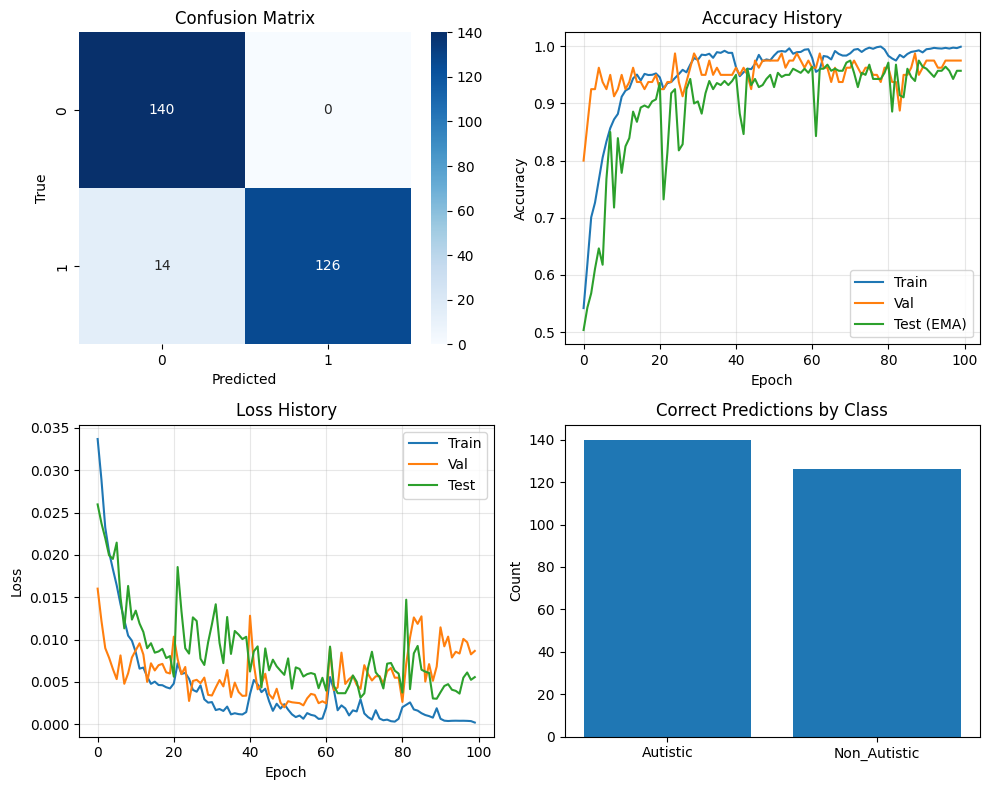

ValueError: not enough values to unpack (expected 6, got 3)

In [5]:

# Main Execution

def main():

    print("ASD CLASSIFICATION - ENHANCED DENSERESNET")


    # Load data with balancing
    dataloaders, class_names, class_weights = create_dataloaders_with_balance()

    # Create model
    print("\nCreating Enhanced DenseResNet model")
    model = EnhancedDenseResNet(num_classes=len(class_names), freeze_backbone=True)
    model.unfreeze_layers()

    # Create trainer
    print("\nCreating Optimized Trainer")
    trainer = OptimizedTrainer(model, dataloaders, class_names, class_weights, device)

    # Train fully (no early stopping)
    trainer.train_full(config.NUM_EPOCHS)

    # Final evaluation
    test_loss, test_acc, test_f1, cm, preds, labels = trainer.final_evaluation()

    # Summary

    print("TRAINING COMPLETE - FINAL SUMMARY")

    print("\nSaved artifacts:")
    print("   - final_best_model.pth")
    print("   - checkpoint_epoch_*.pth (if SAVE_FREQ > 0)")
    print("   - final_analysis.png")

    return trainer, test_acc



# Run

if __name__ == "__main__":
    trainer, test_acc = main()


In [22]:
# ======================================================
# Evaluate checkpoint_epoch_70.pth metrics
# ======================================================

import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load dataloaders (ensure your dataset paths are correct)
dataloaders, class_names, _ = create_dataloaders_with_balance()

# 3. Load model structure
model = EnhancedDenseResNet(num_classes=len(class_names), freeze_backbone=True)
model.unfreeze_layers()
model = model.to(device)

# 4. Load checkpoint for epoch 70
checkpoint_path = "checkpoint_epoch_70.pth"  # change path if needed
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# 5. Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 6. Metrics
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
f1 = f1_score(all_labels, all_preds, average="weighted")
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")  # sensitivity
cm = confusion_matrix(all_labels, all_preds)
specificity = np.mean([cm[i,i]/(cm[i,:].sum()-cm[i,i]+cm[i,i]) for i in range(len(class_names))])  # per-class specificity avg

# 7. Print results
print("\n===== Metrics for Epoch 70 =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"Specificity (average): {specificity:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Confusion Matrix:")
print(cm)


Using device: cuda

Loading datasets with class balancing...
Class counts (train): {'Autistic': 1263, 'Non_Autistic': 1263}
Loss weights (for criterion): tensor([1., 1.])
Classes: ['Autistic', 'Non_Autistic']
Train: 2526 images
Val:   80 images
Test:  280 images

===== Metrics for Epoch 70 =====
Accuracy:  0.9821
F1-Score:  0.9821
Precision: 0.9828
Sensitivity (Recall): 0.9821
Specificity (average): 0.9821

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.97      1.00      0.98       140
Non_Autistic       1.00      0.96      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280

Confusion Matrix:
[[140   0]
 [  5 135]]


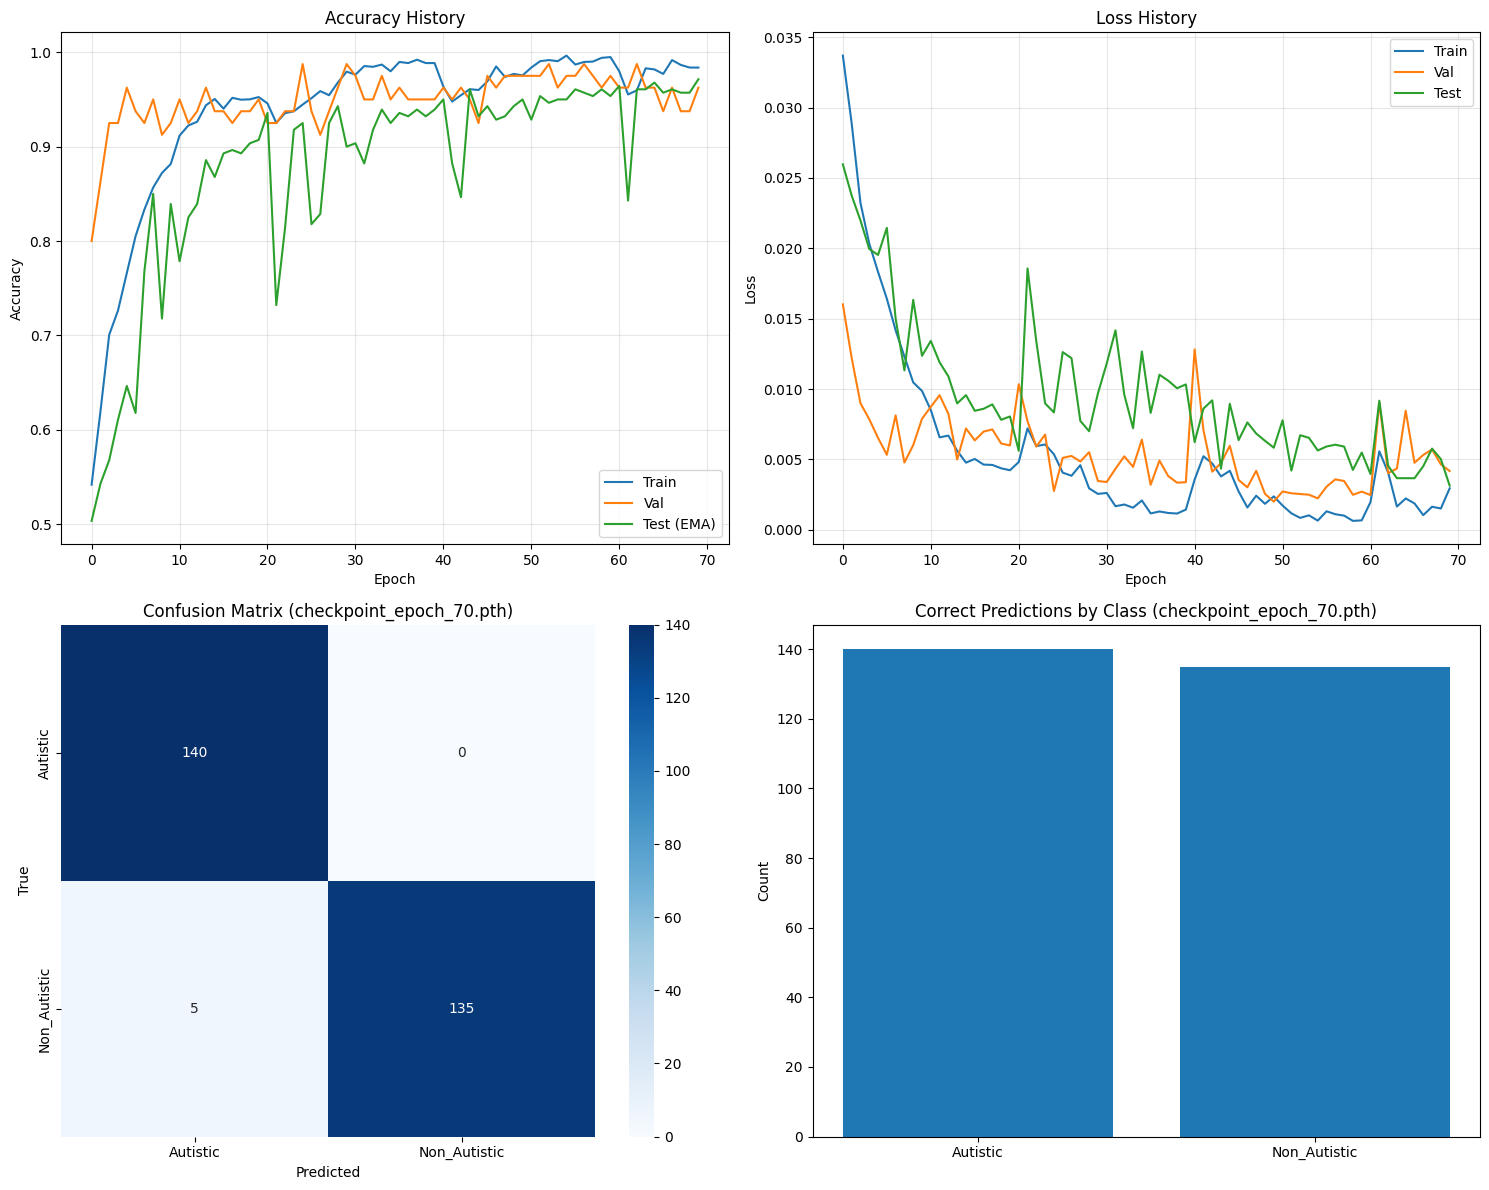

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ======================================================
# Load checkpoint (e.g., epoch 70 or final_best_model)
# ======================================================
checkpoint_path = "checkpoint_epoch_70.pth"  # replace with your checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract history if saved
history = checkpoint.get("history", None)
if history is None:
    raise ValueError("No training history found in checkpoint!")

# Load model for evaluation
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# ======================================================
# Evaluate on test set
# ======================================================
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = checkpoint.get("class_names", ["Class0", "Class1"])

# ======================================================
# Plotting
# ======================================================
plt.figure(figsize=(15, 12))

# 1) Accuracy curves
plt.subplot(2,2,1)
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.plot(history["test_acc"], label="Test (EMA)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy History")
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Loss curves
plt.subplot(2,2,2)
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Val")
plt.plot(history["test_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.grid(True, alpha=0.3)

# 3) Confusion matrix heatmap
plt.subplot(2,2,3)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix ({checkpoint_path})")
plt.ylabel("True")
plt.xlabel("Predicted")

# 4) Correct predictions by class
plt.subplot(2,2,4)
class_correct = [cm[i,i] for i in range(len(class_names))]
plt.bar(class_names, class_correct)
plt.title(f"Correct Predictions by Class ({checkpoint_path})")
plt.ylabel("Count")

plt.tight_layout()
plt.savefig(f"training_analysis_{checkpoint_path}.png", dpi=300, bbox_inches="tight")
plt.show()
